# Описание проекта. Телеком

Оператор связи «ТелеДом» хочет бороться с оттоком клиентов. Для этого его сотрудники начнут предлагать промокоды и специальные условия всем, кто планирует отказаться от услуг связи. Чтобы заранее находить таких пользователей, «ТелеДому» нужна модель, которая будет предсказывать, разорвёт ли абонент договор. Команда оператора собрала персональные данные о некоторых клиентах, информацию об их тарифах и услугах. Ваша задача — обучить на этих данных модель для прогноза оттока клиентов.

**Описание услуг**

Оператор предоставляет два основных типа услуг:

- Стационарную телефонную связь. Телефон можно подключить к нескольким линиям одновременно.

- Интернет. Подключение бывает двух типов: через телефонную линию `DSL` (англ. `digital subscriber line` — «цифровая абонентская линия») или оптоволоконный кабель (англ. `fiber optic`).

Также абонентам доступен ряд услуг:

- Интернет-безопасность: антивирус (`Device Protection`) и блокировка опасных сайтов (`Online Security`);
- Выделенная линия технической поддержки (`Tech Support`);
- Облачное хранилище файлов для резервного копирования данных (`Online Backup`);
- Стриминговое телевидение (`Streaming TV`) и каталог фильмов (`Streaming Movies`).

За услуги клиенты могут платить ежемесячно или раз в 1–2 года. Доступны различные способы расчёта и возможность получить электронный чек.

**Описание данных**

Данные хранятся в базе данных `PostgreSQL`.

Она состоит из нескольких таблиц:

- `contract` — информация о договорах;
- `personal` — персональные данные клиентов;
- `internet` — информация об интернет-услугах;
- `phone` — информация об услугах телефонии.

*Таблица* `telecom.contract`

- `customerID` — `ID` абонента;
- `BeginDate` — дата начала действия договора;
- `EndDate` — дата окончания действия договора;
- `Type` — тип оплаты: раз в год-два или ежемесячно;
- `PaperlessBilling` — электронный расчётный лист;
- `PaymentMethod` — тип платежа;
- `MonthlyCharges` — расходы за месяц;
- `TotalCharges` — общие расходы абонента.

*Таблица* `personal`

- `customerID` — `ID` пользователя;
- `gender` — пол;
- `SeniorCitizen` — является ли абонент пенсионером;
- `Partner` — есть ли у абонента супруг или супруга;
- `Dependents` — есть ли у абонента дети.

*Таблица* `telecom.internet`

- `customerID` — `ID` пользователя;
- `InternetService` — тип подключения;
- `OnlineSecurity` — блокировка опасных сайтов;
- `OnlineBackup` — облачное хранилище файлов для резервного копирования данных;
- `DeviceProtection` — антивирус;
- `TechSupport` — выделенная линия технической поддержки;
- `StreamingTV` — стриминговое телевидение;
- `StreamingMovies` — каталог фильмов.

*Таблица* `telecom.phone`

- `customerID` — `ID` пользователя;
- `MultipleLines` — подключение телефона к нескольким линиям одновременно.

Информация о договорах актуальна на 1 февраля 2020

**План работы.**

1. Загрузка данных.
2. Исследовательский анализ и предобработка данных
   
   - анализ таблиц по отдельности,
   - проверка полноты данных,
   - объединение таблиц,
   - обработка пропусков и аномалий,
   - выделение целевого признака, 
   - анализ признаков на основании целевого признака.
   - генерация доп. признаков, если потребуется.
   
3. Обучение моделей
   
   - решающее дерево,
   - бустинг,
   - нейронная сеть.

4. Тестирование лучшей модели и интерпретация результатов
   
   - метрика на тестовой выборке,
   - матрица ошибок,
   - важность признаков для модели,
   - график зависимости входного и целевого признаков.
   
5. Вывод.

## Импорт необходимых библиотек.

**Импорт библиотек.**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from math import ceil

from sqlalchemy import create_engine
from functools import reduce
from tqdm import tqdm

import scipy.stats as ss

from sklearn.preprocessing import OrdinalEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest, chi2

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.utils.class_weight import compute_class_weight

from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve, precision_recall_curve

from sklearn.inspection import PartialDependenceDisplay

from sklearn.tree import DecisionTreeClassifier
from catboost import CatBoostClassifier

import torch
import torch.nn as nn

import warnings

warnings.filterwarnings("ignore")

pd.set_option("display.max_columns", None)
pd.set_option("max_colwidth", 100)

RANDOM = 21082023
np.random.seed(RANDOM)
torch.manual_seed(RANDOM)
torch.use_deterministic_algorithms(True)

## Функции для дальнейшей работы

**Функция для получения информации из таблицы БД.**

In [2]:
def get_data_from_database(table):
    '''
    Функция для создания датасета из определенной таблицы БД.

    Параметры:
    
     table: таблица из БД из которой будет создан датасет.
           
    Возвращаемые значения:
    
     Функция возвращает созданный датафрейм: dataframe.

    '''

    # переменная query с sql запросом к таблице table
    query = f'SELECT * FROM {table};'
    # создание датафрема в переменную dataframe
    dataframe = pd.read_sql_query(query, con=engine)

    return dataframe

**Функция проверки загрузки: вывод первых 5 строк, информации о датафрейме и наличии дубликатов.**

In [3]:
def display_dataset_info(dataset):
    '''
    Функция проверки загрузки: вывод первых 5 строк, информации о датафрейме и наличии дубликатов.

    Параметры:
    
     dataset: исследуемый датасет.

    '''

    display(dataset.head())
    print()
    dataset.info()
    print()
    print(f'Дубликаты в данных: {dataset.duplicated().sum()}')

**Функция `countplot_drow`.**

In [4]:
def countplot_drow(dataset,
                   x_ax,
                   figsize=(16, 10),
                   hue=None,
                   yscale=False,
                   font_xtick=14,
                   rotation_annot=0,
                   size_annot=14,
                   color_palette='bright',
                   title_plot='',
                   x_label='',
                   y_label='',
                   title_font_size=20,
                   xlabel_font_size=18,
                   ylabel_font_size=18,
                   hue_legend_list=[]):
    '''
    Функция для визуализации данных в виде столбчатой диаграммы Countplot. То же самое, что и барплот, 
    только функция уже явно задана, и она считает количество значений в каждой категории.
    
    Параметры:
    dataset: датасет данными
    x_ax: столбец с категориями для оси Х
    figsize: размер диаграммы, по умолчанию (16, 10) 
    hue: аргумент для групппировки данных по категории, по умолчанию None 
    y_scale: логарифмическое масштабирование, по умолчанию False
    float_annot: формат вывода подписей цифровых значений столбцов в float формате, по умолчанию False
    font_xtick: размер шрифта для подписей по оси Х
    rotation_annot: угол наклона выведенных значений к каждому столбцу, по умолчанию 0
    size_annot: размер шрифта для вывода значений столбцов диаграммы, по умолчанию 14
    color_palette: цветовая палитра, по умолчанию 'bright'
    title_plot='': название диаграммы, по умолчанию пустая строка
    x_label='': название оси Х, по умолчанию пустая строка
    y_label='': название оси Y, по умолчанию пустая строка
    title_font_size: размер шрифта для названия диаграммы, по умолчанию 20
    xlabel_font_size: размер шрифта для названия по оси Х, по умолчанию 18
    ylabel_font_size: размер шрифта для названия по оси Y, по умолчанию 18
    hue_legend_list: список значений для легенды диаграммы, по умолчанию пустой 

    '''

    sns.set_theme(style="darkgrid")

    fig = plt.subplots(figsize=figsize)

    ax = sns.countplot(data=dataset, x=x_ax, hue=hue, palette=color_palette)

    if yscale:
        ax.set_yscale('log')

    ax.set_xticklabels(ax.get_xticklabels(),
                       rotation=45,
                       horizontalalignment='right',
                       fontsize=font_xtick)

    for bar in ax.patches:
        if bar.get_height() > 0:
            ax.annotate(format(bar.get_height(), '.0f'),
                        (bar.get_x() + bar.get_width() / 2, bar.get_height()),
                        ha='center',
                        va='center',
                        size=size_annot,
                        xytext=(0, 8),
                        textcoords='offset points',
                        rotation=rotation_annot)

    legend_handles, _ = ax.get_legend_handles_labels()

    ax.legend(legend_handles, hue_legend_list, bbox_to_anchor=(1, 1))
    ax.set_title(title_plot, fontsize=title_font_size)
    ax.set_xlabel(x_label, fontsize=xlabel_font_size)
    ax.set_ylabel(y_label, fontsize=ylabel_font_size)

    plt.show()

**Функция `barplot_drow`.**

In [5]:
def barplot_drow(dataset,
                 x_ax=None,
                 y_ax=None,
                 figsize=(16, 10),
                 hue=None,
                 yscale=False,
                 float_annot=False,
                 group_by=False,
                 col_to_aggregate=None,
                 font_xtick=14,
                 rotation_xtick=0,
                 rotation_annot=0,
                 horizontalalignment_xtick='center',
                 size_annot=14,
                 color_palette='bright',
                 title_plot='',
                 x_label='',
                 y_label='',
                 title_font_size=20,
                 xlabel_font_size=18,
                 ylabel_font_size=18):
    '''
    Функция для визуализации данных в виде столбчатой диаграммы Barplot.

    Параметры:
    dataset: датасет данными
    x_ax: столбец с категориями для оси Х
    y_ax: столбец с количественными значениями для категориальных переменных для оси Y
    figsize: размер диаграммы, по умолчанию (16, 10) 
    hue: аргумент для групппировки данных по категории, по умолчанию None 
    y_scale: логарифмическое масштабирование, по умолчанию False
    group_by: т.к. для барплот нужны числовые значения по исследуемому параметру, то если их нету
              через группировку их можно создать, по умолчанию False
    col_to_aggregate: колонка для аггрегации в группировке, задействуется при group_by=True, по умолчанию None
    float_annot: формат вывода подписей цифровых значений столбцов в float формате, по умолчанию False
    font_xtick: размер шрифта для подписей по оси Х
    rotation_xtick: поворот подписей по оси х, по умолчанию 0
    rotation_annot: угол наклона выведенных значений к каждому столбцу, по умолчанию 0
    horizontalalignment_xtick: выравнивание подписей по оси х, по умолчанию 'center',
    size_annot: размер шрифта для вывода значений столбцов диаграммы, по умолчанию 14
    color_palette: цветовая палитра, по умолчанию 'bright'
    title_plot='': название диаграммы, по умолчанию пустая строка
    x_label='': название оси Х, по умолчанию пустая строка
    y_label='': название оси Y, по умолчанию пустая строка
    title_font_size: размер шрифта для названия диаграммы, по умолчанию 20
    xlabel_font_size: размер шрифта для названия по оси Х, по умолчанию 18
    ylabel_font_size: размер шрифта для названия по оси Y, по умолчанию 18

    '''

    sns.set_theme(style="darkgrid")

    fig = plt.subplots(figsize=figsize)

    if group_by:
        df = dataset.groupby(x_ax)[col_to_aggregate].agg(['count'
                                                          ]).reset_index()
        ax = sns.barplot(data=df,
                         x=x_ax,
                         y='count',
                         palette=color_palette,
                         hue=hue)
    else:

        ax = sns.barplot(data=dataset,
                         x=x_ax,
                         y=y_ax,
                         palette=color_palette,
                         hue=hue)

    if yscale:
        ax.set_yscale('log')

    ax.set_xticklabels(ax.get_xticklabels(),
                       rotation=rotation_xtick,
                       horizontalalignment=horizontalalignment_xtick,
                       fontsize=font_xtick)

    for bar in ax.patches:
        if not float_annot:
            ax.annotate(format(bar.get_height(), '.0f'),
                        (bar.get_x() + bar.get_width() / 2, bar.get_height()),
                        ha='center',
                        va='center',
                        size=size_annot,
                        xytext=(0, 8),
                        textcoords='offset points',
                        rotation=rotation_annot)
        else:
            ax.annotate(format(bar.get_height(), '.2f'),
                        (bar.get_x() + bar.get_width() / 2, bar.get_height()),
                        ha='center',
                        va='center',
                        size=size_annot,
                        xytext=(0, 8),
                        textcoords='offset points',
                        rotation=rotation_annot)

    ax.set_title(title_plot, fontsize=title_font_size)
    ax.set_xlabel(x_label, fontsize=xlabel_font_size)
    ax.set_ylabel(y_label, fontsize=ylabel_font_size)
    plt.show()

**Функция `drow_boxplot`.**

In [6]:
def drow_boxplot(column,
                 figsize=(8, 5),
                 orient='h',
                 title_plot='',
                 x_label='',
                 y_label='',
                 title_font_size=16,
                 xlabel_font_size=14,
                 ylabel_font_size=14):
    '''
    Функция для построения диаграммы размаха
    
    Параметры:    
    column: столбец по поторому строится диаграмма размаха
    figsize: размер диаграммы, по умолчанию (8, 5) 
    orient: ориентация по поризонтали или вертикали, по умолчанию 'h' - горизонтальная 
    title_plot='': название диаграммы, по умолчанию пустая строка
    x_label='': название оси Х, по умолчанию пустая строка
    y_label='': название оси Y, по умолчанию пустая строка
    title_font_size: размер шрифта для названия диаграммы, по умолчанию 16
    xlabel_font_size: размер шрифта для названия по оси Х, по умолчанию 14
    ylabel_font_size: размер шрифта для названия по оси Y, по умолчанию 14
    color_palette: цветовая палитра, по умолчанию 'bright'
    
    '''

    plt.figure(figsize=figsize)

    ax = sns.boxplot(data=column, orient='h', color='g', fliersize=6)

    ax.set_title(title_plot, fontsize=title_font_size)
    ax.set_xlabel(x_label, fontsize=xlabel_font_size)
    ax.set_ylabel(y_label, fontsize=ylabel_font_size)

    plt.show()

**Функция `drow_histplot`.**

In [7]:
def drow_histplot(dataset,
                  column=None,
                  figsize=(12, 6),
                  bins=100,
                  kde=True,
                  hue=None,
                  title_plot='',
                  x_label='',
                  y_label='',
                  title_font_size=16,
                  xlabel_font_size=14,
                  ylabel_font_size=14):
    '''
    Функция для построения диаграммы распределения количественного признака
    
    Параметры:
    dataset: датасет с данными
    column: столбец по поторому строится диаграмма диаграммы распределения
    figsize: размер диаграммы, по умолчанию (12, 6) 
    bins: параметр позволяет управлять ячейками гистограммы, по умолчанию 100,
    kde: один из механизмов, используемых для сглаживания графика гистограммы, по умолчанию True
    hue: параметр позволяющий сопоставить категориальную переменную с цветом полос, по умолчанию None
    title_plot='': название диаграммы, по умолчанию пустая строка
    x_label='': название оси Х, по умолчанию пустая строка
    y_label='': название оси Y, по умолчанию пустая строка
    title_font_size: размер шрифта для названия диаграммы, по умолчанию 16
    xlabel_font_size: размер шрифта для названия по оси Х, по умолчанию 14
    ylabel_font_size: размер шрифта для названия по оси Y, по умолчанию 14
      
    '''

    plt.figure(figsize=figsize)
    ax = sns.histplot(data=dataset, x=column, bins=bins, hue=hue, kde=kde)

    ax.set_title(title_plot, fontsize=title_font_size)
    ax.set_xlabel(x_label, fontsize=xlabel_font_size)
    ax.set_ylabel(y_label, fontsize=ylabel_font_size)

    plt.show()

**Функция для корректировки `total_charges`.** 

In [8]:
def fix_total_charges(dataset):
    '''
    Функция для корректировки total_charges
    
    Параметры:
    
     dataset: исходный датасет.
           
    Возвращаемые значения:
    
     Функция возвращает : dataset с исправленным столбцом total_charges.
     
    - для месячных контрактов - месячный платеж * кол-во месяцев.
    - годовой контракт - месячный платеж * кол-во месяцев * кол-во периодов в 1 год
    - годовой контракт - месячный платеж * кол-во месяцев * кол-во периодов в 2 года
          
    '''

    if dataset['type'] == 'Month-to-month':

        dataset[
            'total_charges'] = dataset['duration'] * dataset['monthly_charges']

    elif dataset['type'] == 'One year':

        dataset['total_charges'] = 12 * dataset['monthly_charges'] * ceil(
            dataset['duration'] / 12)

    else:

        dataset['total_charges'] = 24 * dataset['monthly_charges'] * (ceil(
            dataset['duration'] / 24))

    return dataset

**Функция для подсчета корреляции `Cramers V` между признаками.** 

In [9]:
def cramers_v(x, y):
    
    confusion_matrix = pd.crosstab(x,y)
    chi2 = ss.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2/n
    r,k = confusion_matrix.shape
    phi2corr = max(0, phi2-((k-1)*(r-1))/(n-1))
    rcorr = r-((r-1)**2)/(n-1)
    kcorr = k-((k-1)**2)/(n-1)
    
    return np.sqrt(phi2corr/min((kcorr-1),(rcorr-1)))

**Функция для разбиения датасета на выборки.**

In [10]:
def data_split(dataset,
               target_col=None,
               test_size=0.2,
               valid=False,
               test_valid_size=0.4):
    '''
    Функция разбивает датасет на выборки.

    Параметры:

     data: датасет с данными,
     test_size: размер тестовой выборки, по умолчанию 20% или 0.2, 
     valid: флаг для выбора возможности добавлять валидационную выборку, 
     test_valid_size: размер тестовой и валидационной выборки, по умолчанию 40% или 0.4, в дальнейшем 
                      выборки будут разбиты 50 на 50.

    Возвращаемое значение (результат разбиения на выборки):

     Если valid=False, возвращаются только трейн и тест:

       features_train, target_train, features_test, target_test

     Если valid=True, возвращаются трейн, валид и тест:

       features_train, target_train, features_valid, target_valid, features_test, target_test

    '''

    # выделение признаков
    features = dataset.drop([target_col], axis=1)
    # выделение целевого признака
    target = dataset[target_col]

    # если нужна валидация - разбиваем на train, valid, test в соотношении 60-20-20
    if valid:

        features_train, features_test, target_train, target_test = train_test_split(
            features,
            target,
            test_size=test_valid_size,
            random_state=RANDOM,
            stratify=target)
        features_valid, features_test, target_valid, target_test = train_test_split(
            features_test,
            target_test,
            test_size=.5,
            random_state=RANDOM,
            stratify=target_test)

        print('Тренировочная выборка: ', features_train.shape,
              target_train.shape)
        print('Валидационная выборка: ', features_valid.shape,
              target_valid.shape)
        print('Тестовая выборка: ', features_test.shape, target_test.shape)

        return features_train, target_train, features_valid, target_valid, features_test, target_test

    # если не нужна валидация - разбиваем на train и test в соотношении 80-20
    else:

        features_train, features_test, target_train, target_test = train_test_split(
            features,
            target,
            test_size=test_size,
            random_state=RANDOM,
            stratify=target)

        print('Тренировочная выборка: ', features_train.shape,
              target_train.shape)
        print('Тестовая выборка: ', features_test.shape, target_test.shape)

        return features_train, target_train, features_test, target_test

**Функция для создания моделей нейросети.**

In [11]:
def create_model(neurons_list,
                 drop=False,
                 batch_norm=False,
                 info=True,
                 p_1=0,
                 p_2=0):
    '''
    Функция создает модель для обучения нейронной сети.
    
    Параметры:
    neurons_list: список с количеством нейронов для слоев нейросети
    drop: параметр, определяющий нужен ли dropout, по умолчанию False
    batch_norm: параметр, определяющий нужен ли BatchNorm, по умолчанию False
    info: параметр, определяющий нужен ли вывод информации по созданной модели, по умолчанию True
    p_1: параметр dropout для нечётного слоя, по умолчанию 0
    p_2: параметр dropout для чётного слоя, по умолчанию 0
    
    Возвращаемое значение: созданная модель net
    
    '''
    net_layers = []

    # создание базовой модели без dropout и BatchNorm
    if not drop and not batch_norm:

        for i in range(1, len(neurons_list) - 1):

            # добавляется полносвязный слой
            net_layers.append(nn.Linear(neurons_list[i - 1], neurons_list[i]))
            # добавляется функция активации
            net_layers.append(nn.ReLU())

        # добавляется выходной слой
        net_layers.append(nn.Linear(neurons_list[-2], neurons_list[-1]))
        # добавляется функция активации в выходной слой
        net_layers.append(nn.Sigmoid())
        # модель на выходе
        net = nn.Sequential(*net_layers)

    # создание модели без dropout, но с BatchNorm
    elif batch_norm and not drop:

        for i in range(1, len(neurons_list) - 1):

            # добавляется полносвязный слой
            net_layers.append(nn.Linear(neurons_list[i - 1], neurons_list[i]))
            # добавляется BatchNorm1d
            net_layers.append(nn.BatchNorm1d(neurons_list[i]))
            # добавляется функция активации
            net_layers.append(nn.ReLU())

        # добавляется выходной слой
        net_layers.append(nn.Linear(neurons_list[-2], neurons_list[-1]))
        # добавляется функция активации в выходной слой
        net_layers.append(nn.Sigmoid())
        # модель на выходе
        net = nn.Sequential(*net_layers)

    # создание модели c dropout без BatchNorm
    elif not batch_norm and drop:

        for i in range(1, len(neurons_list) - 1):

            # добавляется полносвязный слой
            net_layers.append(nn.Linear(neurons_list[i - 1], neurons_list[i]))

            # добавляется Dropout
            if (i + 1) % 2 == 0:
                net_layers.append(nn.Dropout(p=p_2))
            else:
                net_layers.append(nn.Dropout(p=p_1))

            # добавляется функция активации
            net_layers.append(nn.ReLU())

        # добавляется выходной слой
        net_layers.append(nn.Linear(neurons_list[-2], neurons_list[-1]))
        # добавляется функция активации в выходной слой
        net_layers.append(nn.Sigmoid())
        # модель на выходе
        net = nn.Sequential(*net_layers)

    else:
        print('BatchNorm и DropOut лучше не использовать')

    if info:
        # вывод информацие о модели если потребуется
        print(f'Структура модели: {net}')

    return net

**Функция инициализации весов нейронной сети.**

In [12]:
def init_weights(layer):
    '''
    
    Функция инициализации весов нейронной сети.
    
    '''

    if type(layer) == nn.Linear:  # Проверка, что слой — полносвязный
        nn.init.normal_(layer.weight, mean=0.5, std=1)
        nn.init.normal_(layer.bias, mean=0.5, std=2)

**Функция для обучения моделей на тренировочной выборке и проверке на валидационной с условием ранней остановки с целью избежать переобучения.**

In [13]:
def train_and_valid(model,
                    epochs,
                    loss_function,
                    features_train,
                    target_train,
                    features_valid,
                    target_valid,
                    rate,
                    batch_size,
                    epoch_step=100,
                    show_report=False):
    '''
    Функция обучает модель на тренировочной выборке и проверяет на валидационной с условием ранней 
    остановки с целью избежать переобучения.
    
    Параметры:
    
     model: модель для обучения
     epochs: количество эпох обучения
     loss_function: функция потерь
     features_train: признаки на тренировочной выборке
     target_train: целевой признак на тренировочной выборке
     features_valid: признаки на валидационной выборке
     target_valid: целевой признак на валидационной выборке
     rate: коэффициент скорости обучения
     batch_size: размер батча
     epoch_step: шаг для проверки на валидации между эпохами обучения, по умолчанию 100
     show_report: при значении True показывает промежуточные результаты обучения в форме:
                  "Эпоха: <номер эпохи> - AUC-ROC ---> <значение метрики>". По умолчанию False
    
    Возвращаемые значения:
     
     Функция возвращает метрику auc-roc: current_roc_auc и непосредственно модель: model_work.
        
    '''

    # инициализация весов модели при помощи ранее объявленной функции init_weights
    model_work = model
    model_work.apply(init_weights)

    # инициализация оптимизатора для модели, с переданным коэффициентом сходимости rate
    optimizer = torch.optim.Adam(model_work.parameters(), lr=rate)

    # количество батчей
    num_batches = ceil(len(features_train) / batch_size)

    #  изначальное значени метрики для проверки ранней остановки
    min_roc_auc = 0

    # количество значений ошибок при уменьшении значении метрики
    patience = 3

    # счетчик разницы значений метрики в сторону уменьшения
    diff = 0

    score_lst = []

    # информация какая модель обучается
    print()
    print('Идет обучение модели....\nОбучается модель: ', model_work,
          '\nLearning rate --->', rate, '\nРазмер батча -->', batch_size,
          '\nШаг между эпохами на валидации -->', epoch_step, '\n')
    print()

    for epoch in range(1, epochs + 1):
        # перевод модели в режим обучения
        model_work.train()
        # случайна перестановка индексов объектов
        order = np.random.permutation(len(features_train))

        for batch_idx in range(num_batches):
            start_index = batch_idx * batch_size  # номер стартового объекта батча
            optimizer.zero_grad()  # обнуление градиентов

            batch_indexes = order[
                start_index:start_index +
                batch_size]  # индексы объектов текущего обатча
            X_batch = features_train[batch_indexes]
            y_batch = target_train[batch_indexes]
            preds = model_work.forward(X_batch).flatten(
            )  # прямое распространение на обучающих данных
            loss_value = loss_function(
                preds, y_batch)  # вычисление значения функции потерь
            loss_value.backward()  # вычисление градиентов
            optimizer.step()  # один шаг оптимизации весов

        if epoch % epoch_step == 0 or epoch == epochs:
            # перевод сети в режим предсказания
            model_work.eval()

            with torch.no_grad():
                val_preds = model_work.forward(features_valid).flatten(
                )  # прямое распространение на валидации
                
                val_preds = torch.round(val_preds)
                
                score = roc_auc_score(target_valid_nn,
                                      val_preds)  # вычисление  метрики
                current_roc_auc = score.item(
                )  # присвоение текущей ошибки в переменныю current_roc_auc

                # вывод на экран процессса обучения.
                if show_report:
                    print(f"Эпоха: {epoch} - AUC-ROC ---> {current_roc_auc}")

                # непосредственная проверка на раннюю остановку
                if current_roc_auc <= min_roc_auc:
                    diff += 1
                    score_lst.append(min_roc_auc)

                    if diff == patience:
                        min_roc_auc = score_lst[0]

                        print(
                            'Ранняя остановка!\nЭпоха № ', epoch,
                            '\nAUC-ROC модели на валидации после ранней остановки: ',
                            score_lst[0])
                        print('\nМодель обучена!')

                        return (model_work, min_roc_auc)
                else:
                    diff = 0
                    score_lst = []

                min_roc_auc = current_roc_auc

    print('Эпохи закончились....\n')
    print(
        f'Модель обучена! AUC-ROC модели на валидации: ---> {current_roc_auc}')

    # возврат модели и метрики на валидации
    return (model_work, current_roc_auc)

**Функция получения результатов предсказаний модели и метрики на тестовой выборке.**

In [14]:
def test(model, features_test, target_test):
    '''
    Функция получения результатов предсказаний модели и метрики RMSE на тестовой выборке..
    
    Параметры:
    
     model: модель для обучения
     features_test: признаки на тестовой выборке
     target_test: целевой признак на тестовой выборке
    
    Возвращаемые значения:
    
     Функция возвращает метрику AUC-ROC: current_roc_auc и предсказания модели: test_preds.
        
    '''
    # перевод сети в режим предсказания

    model.eval()
    with torch.no_grad():

        test_preds = model.forward(
            features_test).flatten()  # прямое распространение на тесте

        score = roc_auc_score(target_test_nn,
                              test_preds)  # вычисление  метрики
        current_roc_auc = score.item(
        )  # присвоение текущей ошибки в переменныю current_roc_auc
        test_preds = torch.round(test_preds)

    # возврат метрики и предсказаний модели.
    return (current_roc_auc, test_preds.detach())

**Функция `drow_roc_curve`.**

In [15]:
def drow_roc_curve(target, predicted_probalities, model_name=''):
    '''
    Функция для построения roc-кривой
    
    Параметры:
    
     target: столбец с целевым признаком
     predicted_probalities: предсказанные вероятности класса 1
     model_name: имя модели для описания в легенде, по умолчанию пустая строка
              
    '''

    plt.figure(figsize=[12, 9])

    fpr, tpr, thresholds = roc_curve(target, predicted_probalities)

    plt.plot([0, 1], [0, 1], linestyle='--', label='Случайная модель')
    plt.plot(fpr, tpr, label=model_name)

    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])

    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")

    plt.legend(loc='lower right', fontsize='x-large')

    plt.title("ROC-кривая")
    plt.show()

**Функция `drow_pr_curve`.**

In [16]:
def drow_pr_curve(features, target, treshold=True):
    '''
    Функция для построения pr-кривой и нахождения лучшего трешхолда
    
    Параметры:
    
     features: признаки модели
     target: столбец с целевым признаком
     treshold: параметр для инизиализации лучшего treshold, рекомендуется только для train, по умолчанию True
              
    '''

    target_score = best_model.predict_proba(features)[:, 1]

    precision, recall, thresholds = precision_recall_curve(
        target, target_score)

    if treshold:

        fscore = (2 * precision * recall) / (precision + recall)

        ix = np.argmax(fscore)

        best_treshold = thresholds[ix]

        print('Лучший Threshold = %.2f' % best_treshold)

    fig, ax = plt.subplots()
    ax.plot(recall, precision, color='purple', label='Модель')

    if treshold:

        ax.scatter(recall[ix],
                   precision[ix],
                   marker='o',
                   color='black',
                   label='Лучший Threshold')

    ax.set_title('Precision-Recall Curve')
    ax.set_ylabel('Precision')
    ax.set_xlabel('Recall')
    ax.legend()

    plt.show()

**Функция `drow_confusion_matrix`.**

In [17]:
def drow_confusion_matrix(conf_matrix):
    '''
    Функция для построения матрицы ошибок
    
    Параметры:
    
     conf_matrix: матрица ошибок
              
    '''

    plt.figure(figsize=(12, 8))

    classes = [
        "True Negative", "False Positive", "False Negative", "True Positive"
    ]

    values = ["{0:0.0f}".format(x) for x in conf_matrix.flatten()]

    percentages = [
        "{0:.1%}".format(x)
        for x in conf_matrix.flatten() / np.sum(conf_matrix)
    ]

    combined = [
        f"{i}\n{j}\n{k}" for i, j, k in zip(classes, values, percentages)
    ]
    combined = np.asarray(combined).reshape(2, 2)

    ax = sns.heatmap(conf_matrix, annot=combined, fmt="", cmap='YlGnBu')

    ax.set(title='Confusion Matrix')
    ax.set(xlabel='Predicted', ylabel='Actual')

    plt.show()

**Функция `conf_matrix_result`.**

In [18]:
def conf_matrix_result(conf_matrix):
    '''
    Функция для интерпретации результатов матрицы ошибок
    
    Параметры:
    
     conf_matrix: матрица ошибок
     
    Выводит на экран:
    
     - количество предсказаний,
     - accuracy,
     - долю ошибок,
     - recall,
     - precision.
              
    '''

    TN = conf_matrix[0][0]
    FP = conf_matrix[0][1]
    FN = conf_matrix[1][0]
    TP = conf_matrix[1][1]

    total = TN + TP + FP + FN

    acc = round((TP + TN) / total, 4)
    recall = round(TP / (TP + FN), 4)
    precision = round(TP / (TP + FP), 4)

    print('Всего предсказаний:', total)
    print(f'Правильно предсказанные ответы (Accuracy): {acc}')
    print(f'Ошибки в прогнозах: {round(1 - acc, 4)}')
    print(f'Recall: {recall}')
    print(f'Precision: {precision}')

## Загрузка датасетов 

**Конфигурация для подключения к БД.**

In [19]:
db_config = {
    'user': 'praktikum_student',  # имя пользователя,
    'pwd': 'Sdf4$2;d-d30pp',  # пароль,
    'host': 'rc1b-wcoijxj3yxfsf3fs.mdb.yandexcloud.net',
    'port': 6432,  # порт подключения,
    'db': 'data-science-final'  # название базы данных,
}

connection_string = 'postgresql://{}:{}@{}:{}/{}'.format(
    db_config['user'],
    db_config['pwd'],
    db_config['host'],
    db_config['port'],
    db_config['db'],
)

In [20]:
engine = create_engine(connection_string)

### Датасет `df_contract`

**Загрузка из БД и вывод информации.**

In [21]:
df_contract = get_data_from_database('telecom.contract')

In [22]:
display_dataset_info(df_contract)

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,4472-LVYGI,2020-02-01,None,Two year,Yes,Bank transfer (automatic),52.55,NaN
1,3115-CZMZD,2020-02-01,None,Two year,No,Mailed check,20.25,NaN
2,3668-QPYBK,2018-08-09,2019-12-01,Month-to-month,Yes,Mailed check,53.85,108.15
3,5709-LVOEQ,2020-02-01,None,Two year,No,Mailed check,80.85,NaN
4,9237-HQITU,2019-01-26,2019-11-01,Month-to-month,Yes,Electronic check,70.70,151.65



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           1869 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7032 non-null   float64
dtypes: float64(2), object(6)
memory usage: 440.3+ KB

Дубликаты в данных: 0


Датасет загружен.

В датасете:

- `7043` записи,
- Дубликатов нету,
- Есть пропуски в столбце `End_date`. Это будет целевой признак. Пропуски означают действующий контракт.
- Есть пропуски в столбце `total_charges`.

Пропуски будут добработаны в исследовательском анализе.

**Преобразование названий столбцов в нижний регистр и `snake_case`.**

In [23]:
df_contract.columns = df_contract.columns.str.replace(
    r"([A-Z]{1,})", r"_\1").str.strip('_').str.lower()

In [24]:
df_contract.head(1)

,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges
0,4472-LVYGI,2020-02-01,None,Two year,Yes,Bank transfer (automatic),52.55,NaN


Датасет готов к дальнейшему исследованию.

### Датасет `df_personal`

**Загрузка из БД и вывод информации.**

In [25]:
df_personal = get_data_from_database('telecom.personal')

In [26]:
display_dataset_info(df_personal)

,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   int64 
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB

Дубликаты в данных: 0


Датасет загружен.

В датасете:

- `7043` записи,
- Дубликатов нету,
- Пропусков нету.

**Преобразование названий столбцов в нижний регистр и `snake_case`.**

In [27]:
df_personal.columns = df_personal.columns.str.replace(
    r"([A-Z]{1,})", r"_\1").str.strip('_').str.lower()

In [28]:
df_personal.head(1)

,customer_id,gender,senior_citizen,partner,dependents
0,7590-VHVEG,Female,0,Yes,No


Датасет готов к дальнейшему исследованию.

### Датасет `df_internet`

**Загрузка из БД и вывод информации.**

In [29]:
df_internet = get_data_from_database('telecom.internet')

In [30]:
display_dataset_info(df_internet)

,c1,c2,c3,c4,c5,c6,c7,c8
0,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
1,7590-VHVEG,DSL,No,Yes,No,No,No,No
2,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
3,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
4,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5518 entries, 0 to 5517
Data columns (total 8 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   c1      5518 non-null   object
 1   c2      5518 non-null   object
 2   c3      5518 non-null   object
 3   c4      5518 non-null   object
 4   c5      5518 non-null   object
 5   c6      5518 non-null   object
 6   c7      5518 non-null   object
 7   c8      5518 non-null   object
dtypes: object(8)
memory usage: 345.0+ KB

Дубликаты в данных: 0


Датасет загружен.

В датасете:

- `5518` записей: `5517` необходимых записей + `1` запись с названиями столбцов,
- Дубликатов нету,
- Пропусков нету.

**Переименование названий столбцов в `snake_case` и удаление первой строки.**

In [31]:
df_internet = df_internet.rename(
    columns={
        'c1': 'customer_id',
        'c2': 'internet_service',
        'c3': 'online_security',
        'c4': 'online_backup',
        'c5': 'device_protection',
        'c6': 'tech_support',
        'c7': 'streaming_tv',
        'c8': 'streaming_movies'
    }).drop([0]).reset_index(drop=True)

In [32]:
df_internet.head(1)

,customer_id,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No


Датасет готов к дальнейшему исследованию.

### Датасет `df_phone`

**Загрузка из БД и вывод информации.**

In [33]:
df_phone = get_data_from_database('telecom.phone')

In [34]:
display_dataset_info(df_phone)

,c1,c2
0,customerID,MultipleLines
1,5575-GNVDE,No
2,3668-QPYBK,No
3,9237-HQITU,No
4,9305-CDSKC,Yes



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362 entries, 0 to 6361
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   c1      6362 non-null   object
 1   c2      6362 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB

Дубликаты в данных: 0


Датасет загружен.

В датасете:

- `6362` записей: `6361` необходимых записей + `1` запись с названиями столбцов,
- Дубликатов нету,
- Пропусков нету.

**Переименование названий столбцов в `snake_case` и удаление первой строки.**

In [35]:
df_phone = df_phone.rename(columns={
    'c1': 'customer_id',
    'c2': 'multiple_lines'
}).drop([0]).reset_index(drop=True)

In [36]:
df_phone.head(1)

,customer_id,multiple_lines
0,5575-GNVDE,No


Датасет готов к дальнейшему исследованию.

## Исследовательский анализ и предобработка данных

### Исследовательский анализ и предобработка данных датасетов по отдельности

**Анализ количества контрактов без ориентировки на целевой признак.**

#### Датасет `df_contract`

**Столбец `type` - тип оплаты: раз в год-два или ежемесячно.**

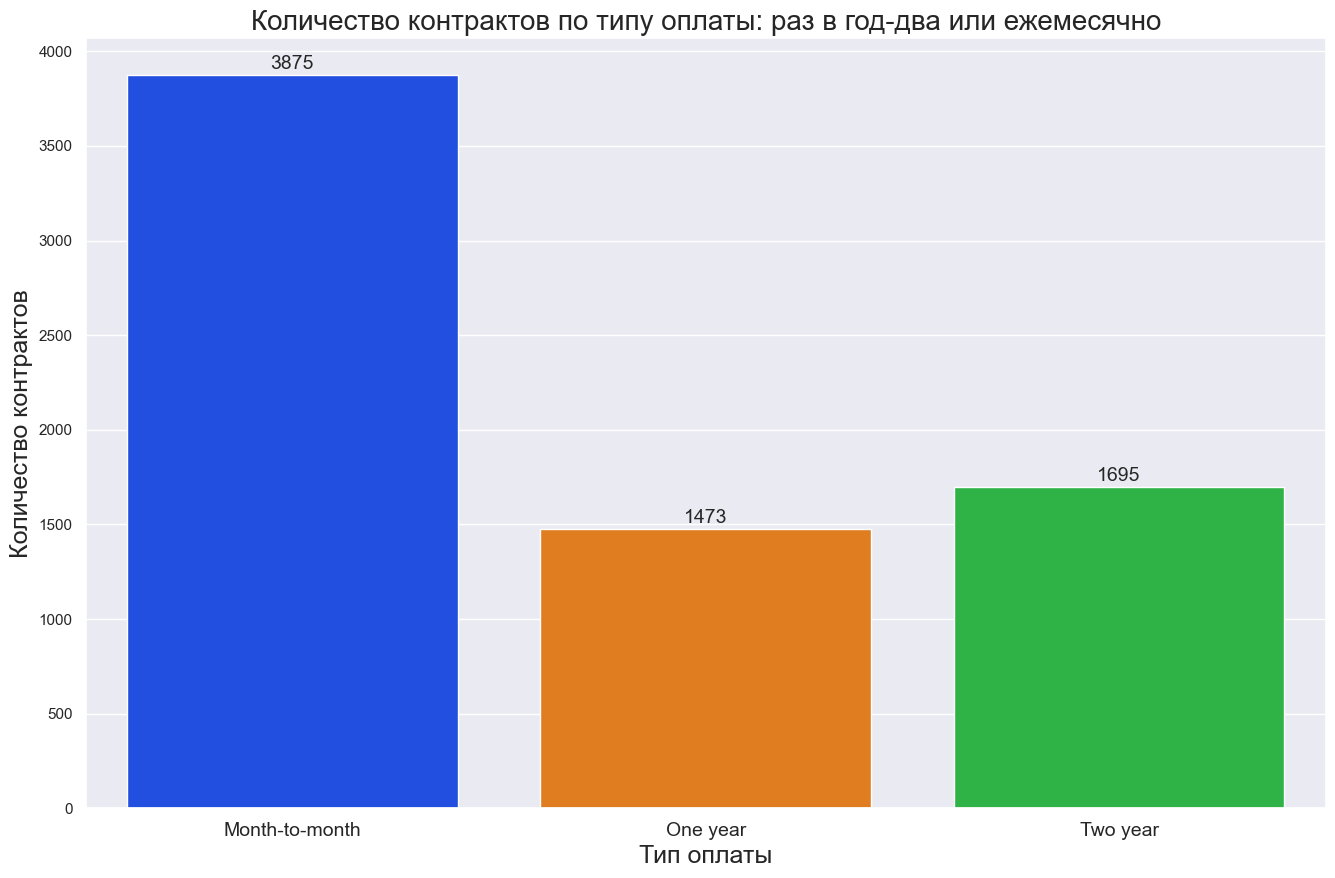

In [37]:
barplot_drow(
    df_contract,
    x_ax='type',
    figsize=(16, 10),
    group_by=True,
    col_to_aggregate='customer_id',
    title_plot=
    'Количество контрактов по типу оплаты: раз в год-два или ежемесячно',
    x_label='Тип оплаты',
    y_label='Количество контрактов')

Из всего количества контрактов наибольшее значение у оплаты раз в месяц, что логично. В основном люди предпочитают платить раз в месяц. Не все готовы заплатить за долгосрочный контракт. Тут либо недостаток средств для разового платежа, либо просто психология..

**Столбец `paperless_billing` - электронный расчётный лист.**

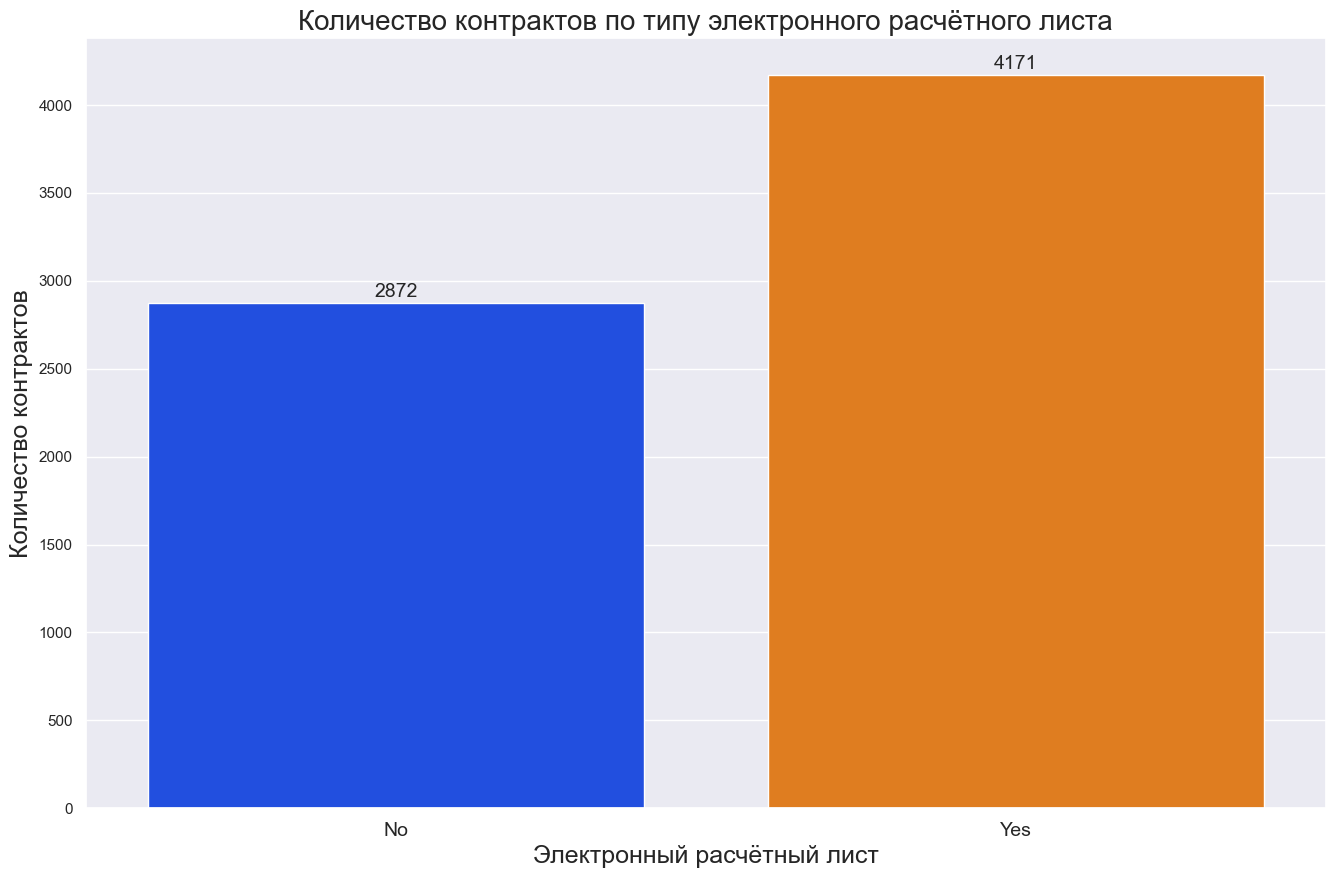

In [38]:
barplot_drow(
    df_contract,
    x_ax='paperless_billing',
    figsize=(16, 10),
    group_by=True,
    col_to_aggregate='customer_id',
    title_plot='Количество контрактов по типу электронного расчётного листа',
    x_label='Электронный расчётный лист',
    y_label='Количество контрактов')

Большинство предпочитает электронный вариант, хотя достаточно людей предпочитает бумажный документооборот.

**Столбец `payment_method` - тип платежа.**

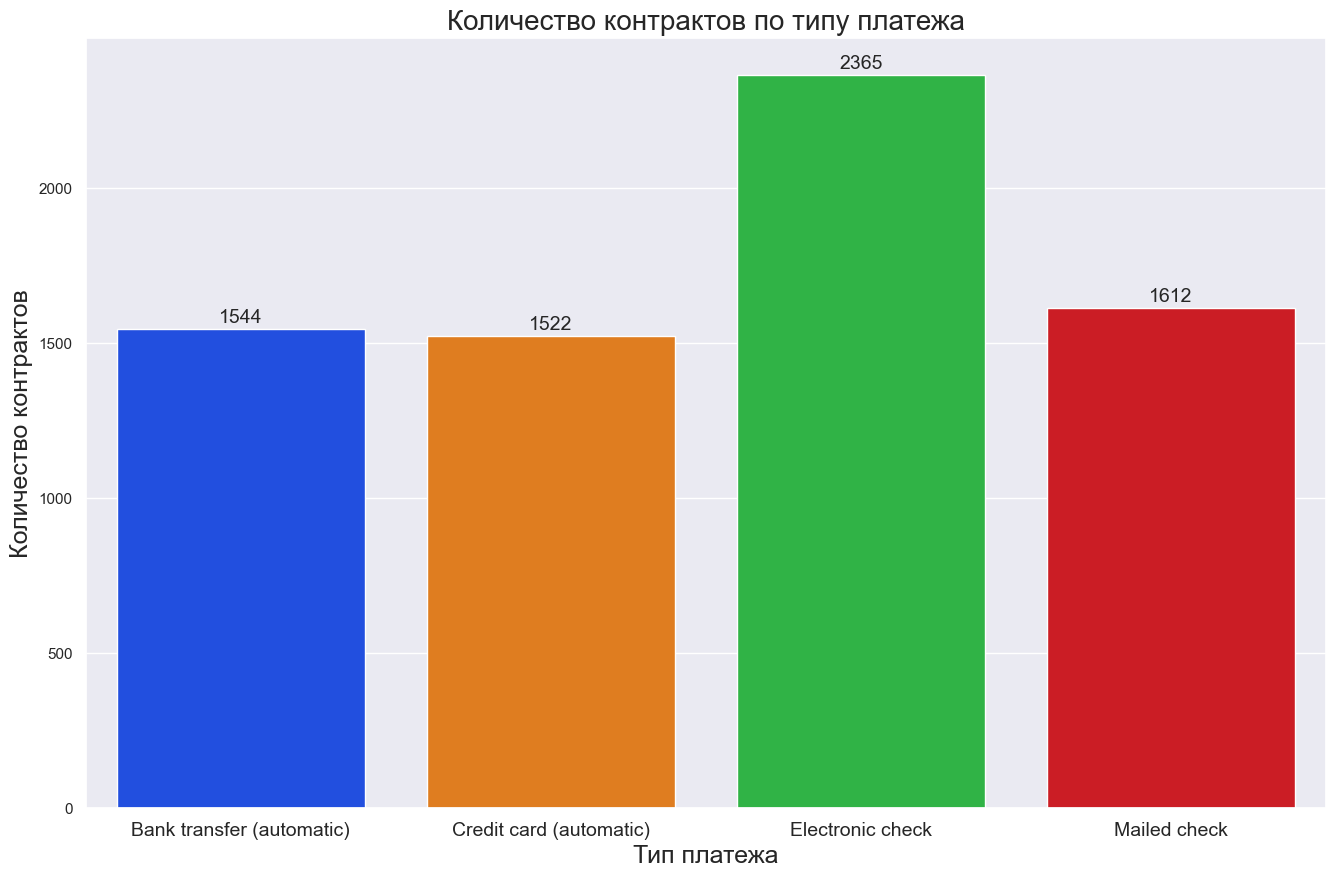

In [39]:
barplot_drow(df_contract,
             x_ax='payment_method',
             figsize=(16, 10),
             group_by=True,
             col_to_aggregate='customer_id',
             title_plot='Количество контрактов по типу платежа',
             x_label='Тип платежа',
             y_label='Количество контрактов')

Большинство у по всей видимости это платеж электронными деньгами. Остальные платежи практичеки равные.

Прежде чем исследовать количественные признаки, необходимо посмотреть зависимость месячных платежей и общих платежей.

In [40]:
df_contract.head(20)

,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges
0,4472-LVYGI,2020-02-01,None,Two year,Yes,Bank transfer (automatic),52.55,NaN
1,3115-CZMZD,2020-02-01,None,Two year,No,Mailed check,20.25,NaN
2,3668-QPYBK,2018-08-09,2019-12-01,Month-to-month,Yes,Mailed check,53.85,108.15
3,5709-LVOEQ,2020-02-01,None,Two year,No,Mailed check,80.85,NaN
4,9237-HQITU,2019-01-26,2019-11-01,Month-to-month,Yes,Electronic check,70.70,151.65
5,9305-CDSKC,2018-12-26,2019-11-01,Month-to-month,Yes,Electronic check,99.65,820.50
6,4367-NUYAO,2020-02-01,None,Two year,No,Mailed check,25.75,NaN
7,1371-DWPAZ,2020-02-01,None,Two year,No,Credit card (automatic),56.05,NaN
8,7892-POOKP,2019-04-27,2019-11-01,Month-to-month,Yes,Electronic check,104.80,3046.05
9,3213-VVOLG,2020-02-01,None,Two year,No,Mailed check,25.35,NaN


Из таблицы вы видны пропуски в `total_charges`. Это просто не проставленная сумма общих платежей согласно контракту.

И видны некоторые несоответствия в данных.

Например строка с индексом `8` - `customer_id` : `7892-POOKP`.

контракт у этого пользователя разорван. Длительность с `2019-04-27` по `2019-11-01`. Это получается 6 с хвостиком месяцев. Поскольку платеж платится вперед, то сумма должна быть за 7 месяцев: 104.8 * 7 = 733.6.

А `total_charges` тут 3046.50 - это получается платежей за 29 месяцев.

Явная ошибка. Отсюда следует, что ошибка либо в `begin_date`, либо непосредственно в `total_charges`.

Примем за факт правильность `begin_date`, тогда `total_charges` можно пересчитать в зависимости от длительности контракта.

Опять же за аксиому можно принять, что деньги при разрыве контракта не возвращаются.

Тогда можно выделить доп признак - длительность контракта в месяцах и в зависимости от длительности контракта пересчитать `total_charges`.

- для месячных контрактов - месячный платеж * кол-во месяцев.
- годовой контракт - месячный платеж * кол-во месяцев * кол-во периодов в 1 год
- годовой контракт - месячный платеж * кол-во месяцев * (кол-во периодов в 2 года

**Приведение столбцов `begin_date` и  `end_date` в формат `datetime`.**

In [41]:
df_contract['begin_date'] = pd.to_datetime(df_contract['begin_date'])
df_contract['end_date'] = pd.to_datetime(df_contract['end_date'])

**Создание столбца `duration` в месяцах.**

Создадим столбец с длительностью контракта в месяцах и огруглим его вверх.

Т.к. платеж вносится вперед, то платежей по действующим контрактам должно быть на 1 месяц больше.

Т.к. есть контракты заключенные в день среза данных, то там должен быть 0, но проплата идет вперед и 0 можно заменить на 1.

In [42]:
df_contract['duration'] = ((df_contract['end_date'].fillna(
    pd.to_datetime('01-02-2020', format='%d-%m-%Y')) -
                            df_contract['begin_date']) /
                           np.timedelta64(1, 'M')).apply(np.ceil).astype('int')

df_contract.loc[df_contract['duration'] == 0, 'duration'] = 1

Теперь можно пофиксить `total_charges`.

**Корректировка `total_charges`.**

In [43]:
tqdm.pandas(desc="Корректировка total_charges")
df_contract = df_contract.progress_apply(fix_total_charges, axis=1)

Корректировка total_charges: 100%|██████████| 7043/7043 [00:00<00:00, 8320.62it/s] 


**Результат.**

In [44]:
df_contract.head(10)

,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,duration
0,4472-LVYGI,2020-02-01,NaT,Two year,Yes,Bank transfer (automatic),52.55,1261.20,1
1,3115-CZMZD,2020-02-01,NaT,Two year,No,Mailed check,20.25,486.00,1
2,3668-QPYBK,2018-08-09,2019-12-01,Month-to-month,Yes,Mailed check,53.85,861.60,16
3,5709-LVOEQ,2020-02-01,NaT,Two year,No,Mailed check,80.85,1940.40,1
4,9237-HQITU,2019-01-26,2019-11-01,Month-to-month,Yes,Electronic check,70.70,707.00,10
5,9305-CDSKC,2018-12-26,2019-11-01,Month-to-month,Yes,Electronic check,99.65,1096.15,11
6,4367-NUYAO,2020-02-01,NaT,Two year,No,Mailed check,25.75,618.00,1
7,1371-DWPAZ,2020-02-01,NaT,Two year,No,Credit card (automatic),56.05,1345.20,1
8,7892-POOKP,2019-04-27,2019-11-01,Month-to-month,Yes,Electronic check,104.80,733.60,7
9,3213-VVOLG,2020-02-01,NaT,Two year,No,Mailed check,25.35,608.40,1


Столбец с корректирован и пропуски заполнены.

**Количественные признаки.**

**Столбец `monthly_charges` -  расходы за месяц.**

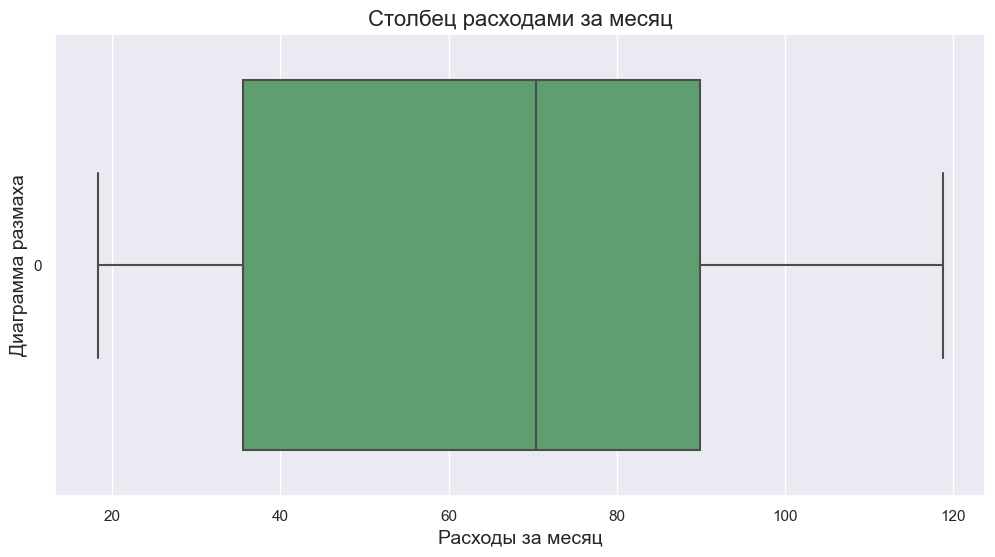

In [45]:
drow_boxplot(column=df_contract['monthly_charges'],
             figsize=(12, 6),
             orient='h',
             title_plot='Столбец расходами за месяц',
             x_label='Расходы за месяц',
             y_label='Диаграмма размаха')

In [46]:
df_contract['monthly_charges'].describe()

count    7043.000000
mean       64.761692
std        30.090047
min        18.250000
25%        35.500000
50%        70.350000
75%        89.850000
max       118.750000
Name: monthly_charges, dtype: float64

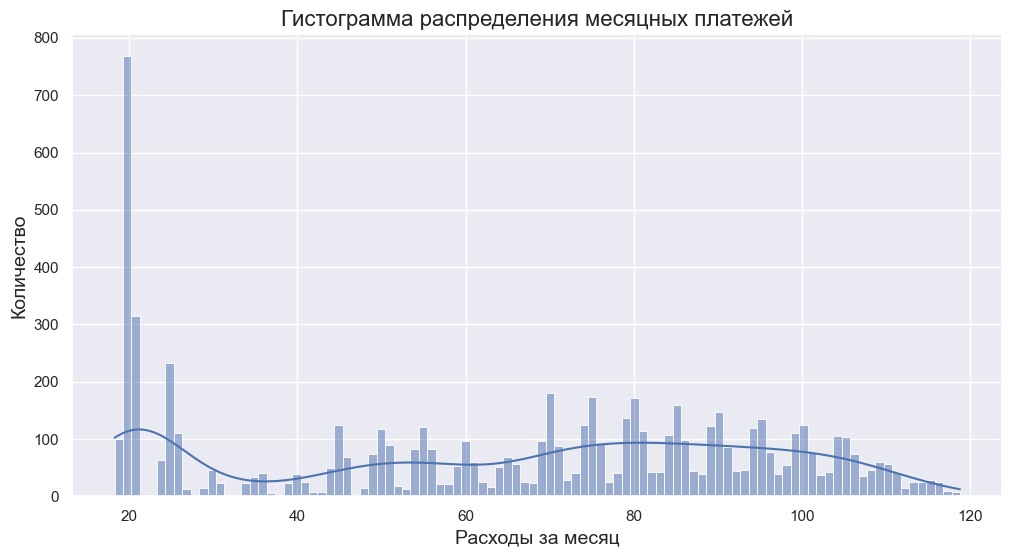

In [47]:
drow_histplot(df_contract,
              column="monthly_charges",
              figsize=(12, 6),
              bins=100,
              kde=True,
              title_plot='Гистограмма распределения месяцных платежей',
              x_label='Расходы за месяц',
              y_label='Количество',
              title_font_size=16,
              xlabel_font_size=14,
              ylabel_font_size=14)

Распределение по гистограмме не является нормальным.

Гистограмма показывает бимодальность - несколько горбов. Это говорит о том, что в самой выборке есть несколько однородных выборок. Здесь, может быть, это завязано на количество услуг.

В среднем клиент платит 64.76 у.е в месяц.

Выбросов в данных нету.

**Столбец `total_charges` -  расходы за месяц.**

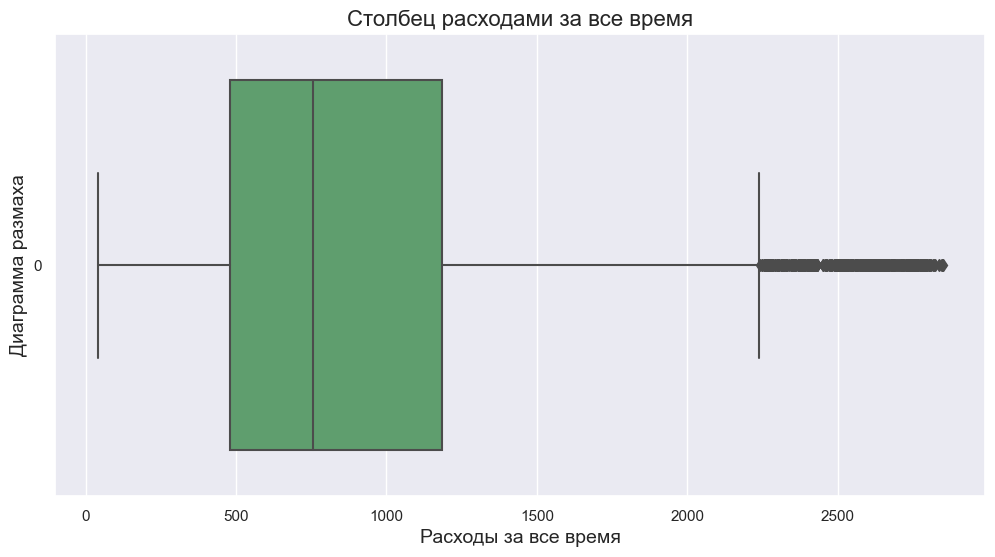

In [48]:
drow_boxplot(column=df_contract['total_charges'],
             figsize=(12, 6),
             orient='h',
             title_plot='Столбец расходами за все время',
             x_label='Расходы за все время',
             y_label='Диаграмма размаха')

In [49]:
df_contract['total_charges'].describe()

count    7043.000000
mean      922.624301
std       630.943438
min        39.700000
25%       481.200000
50%       754.650000
75%      1184.400000
max      2850.000000
Name: total_charges, dtype: float64

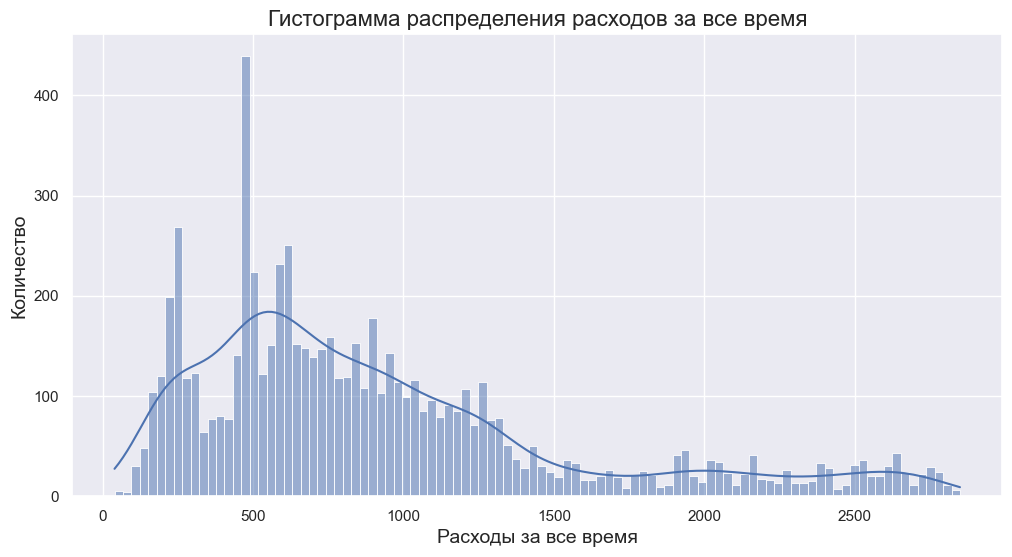

In [50]:
drow_histplot(df_contract,
              column="total_charges",
              figsize=(12, 6),
              bins=100,
              kde=True,
              title_plot='Гистограмма распределения расходов за все время',
              x_label='Расходы за все время',
              y_label='Количество',
              title_font_size=16,
              xlabel_font_size=14,
              ylabel_font_size=14)

In [51]:
df_contract[df_contract['total_charges'] > 2400]

,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,duration
32,3192-NQECA,2018-08-21,2019-11-01,Two year,Yes,Bank transfer (automatic),110.00,2640.0,15
95,6680-NENYN,2019-03-01,2019-12-01,Two year,Yes,Electronic check,104.60,2510.4,10
211,4853-RULSV,2019-04-03,2019-12-01,Two year,Yes,Credit card (automatic),104.00,2496.0,8
223,2382-BCKQJ,2018-09-21,2019-10-01,One year,Yes,Electronic check,100.15,2403.6,13
256,2834-JRTUA,2018-09-02,2019-10-01,Two year,Yes,Electronic check,108.05,2593.2,13
...,...,...,...,...,...,...,...,...,...
6947,0530-IJVDB,2018-12-18,NaT,Two year,Yes,Electronic check,114.60,2750.4,14
6965,6257-DTAYD,2019-03-18,NaT,Two year,Yes,Credit card (automatic),104.15,2499.6,11
6966,4616-ULAOA,2019-03-15,NaT,Two year,Yes,Credit card (automatic),110.80,2659.2,11
7013,9586-JGQKH,2018-11-20,NaT,Two year,Yes,Bank transfer (automatic),105.40,2529.6,15


Распределение скошено вправо , есть «хвост» в правой части распределения.

Медиана 754.65 меньше среднего 754.65.

Есть выбросы, но они связаны исключительно с общими платежами по длинным контрактам.

**Сгенерированный столбец `duration` -  длительность месяце для оплаты.**

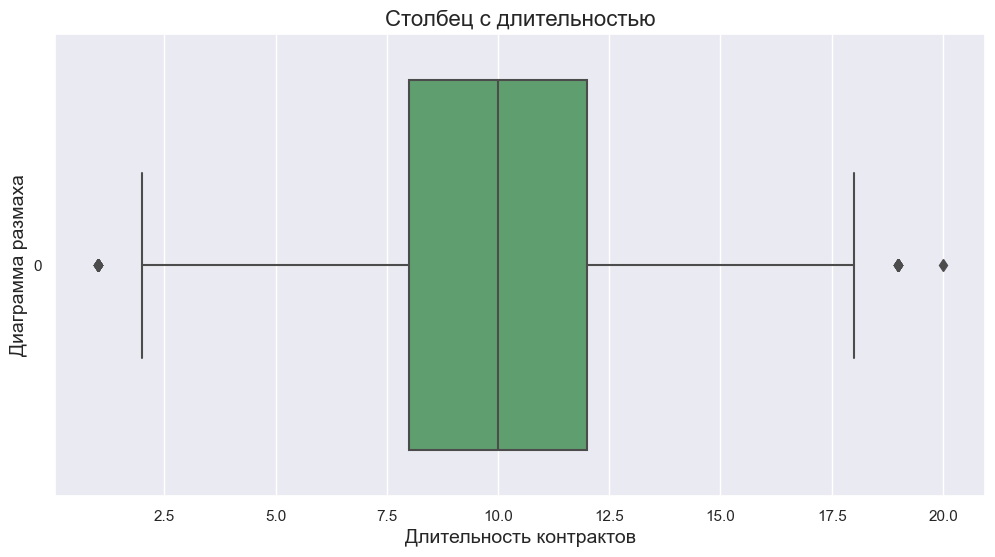

In [52]:
drow_boxplot(column=df_contract['duration'],
             figsize=(12, 6),
             orient='h',
             title_plot='Столбец с длительностью',
             x_label='Длительность контрактов',
             y_label='Диаграмма размаха')

In [53]:
df_contract['duration'].describe()

count    7043.000000
mean       10.274173
std         2.770487
min         1.000000
25%         8.000000
50%        10.000000
75%        12.000000
max        20.000000
Name: duration, dtype: float64

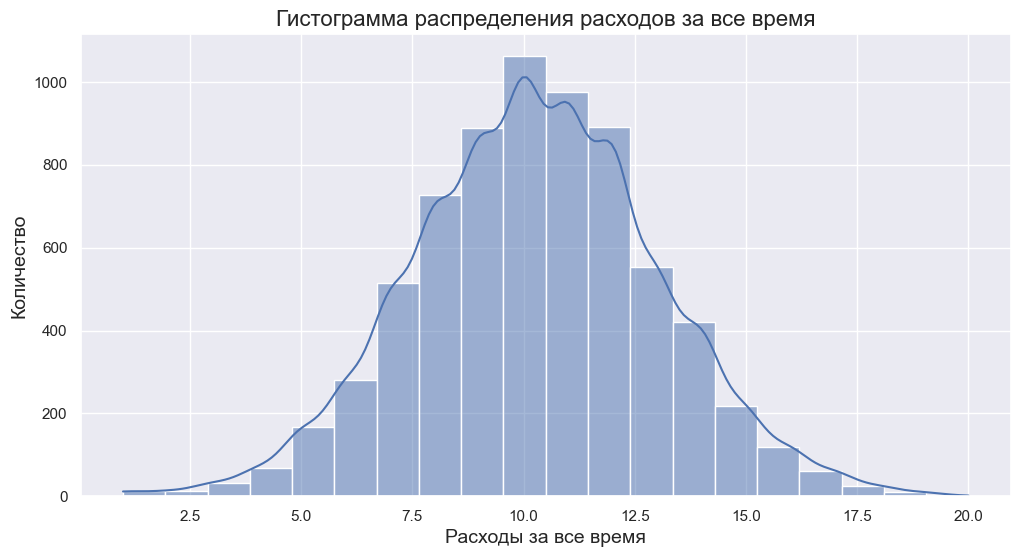

In [54]:
drow_histplot(df_contract,
              column="duration",
              figsize=(12, 6),
              bins=20,
              kde=True,
              title_plot='Гистограмма распределения расходов за все время',
              x_label='Расходы за все время',
              y_label='Количество',
              title_font_size=16,
              xlabel_font_size=14,
              ylabel_font_size=14)

Распределение нормальное. Медиана и среднее практически равны. Есть несколько выбросов.

#### Датасет `df_personal`

**Столбец `gender` - пол.**

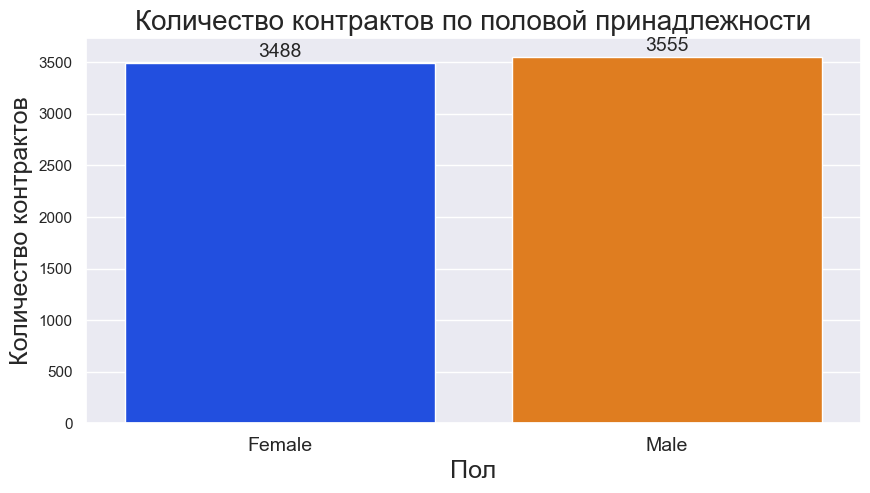

In [55]:
barplot_drow(df_personal,
             x_ax='gender',
             figsize=(10, 5),
             group_by=True,
             col_to_aggregate='customer_id',
             title_plot='Количество контрактов по половой принадлежности',
             x_label='Пол',
             y_label='Количество контрактов')

Практически пополам распределились контракты по половой принадлежности.

**Столбец `senior_citizen` - является ли абонент пенсионером.**

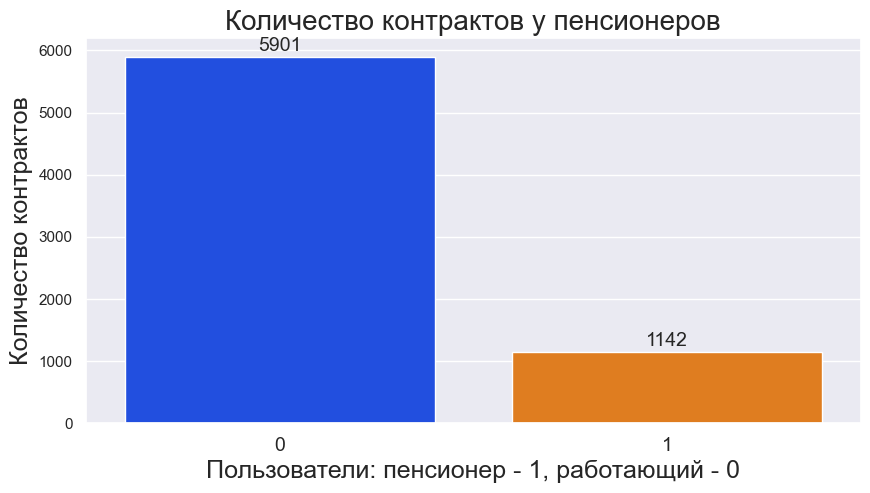

In [56]:
barplot_drow(df_personal,
             x_ax='senior_citizen',
             figsize=(10, 5),
             group_by=True,
             col_to_aggregate='customer_id',
             title_plot='Количество контрактов у пенсионеров',
             x_label='Пользователи: пенсионер - 1, работающий - 0',
             y_label='Количество контрактов')

Логично что работающих больше, чем пенсионеров.

Ради общей структуры преобразуем `1` и `0` в `Yes` и `No`.

In [57]:
tqdm.pandas(desc="Перекодировка")
df_personal['senior_citizen'] = df_personal.progress_apply(
    lambda x: 'No' if x['senior_citizen'] == 0 else 'Yes', axis=1)

Перекодировка: 100%|██████████| 7043/7043 [00:00<00:00, 61036.96it/s]


**Столбец `partner` - есть ли у абонента супруг или супруга.**

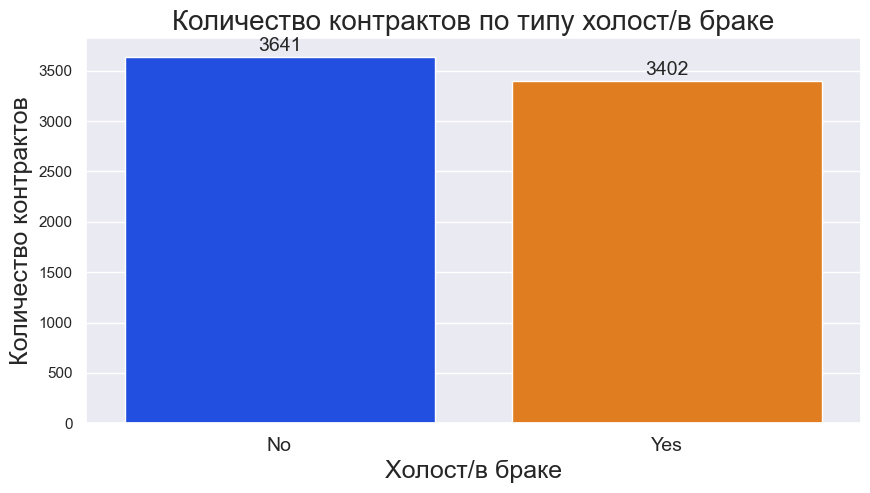

In [58]:
barplot_drow(df_personal,
             x_ax='partner',
             figsize=(10, 5),
             group_by=True,
             col_to_aggregate='customer_id',
             title_plot='Количество контрактов по типу холост/в браке',
             x_label='Xолост/в браке',
             y_label='Количество контрактов')

Холостых немногим больше женатых..

**Столбец `dependents` - есть ли у абонента дети.**

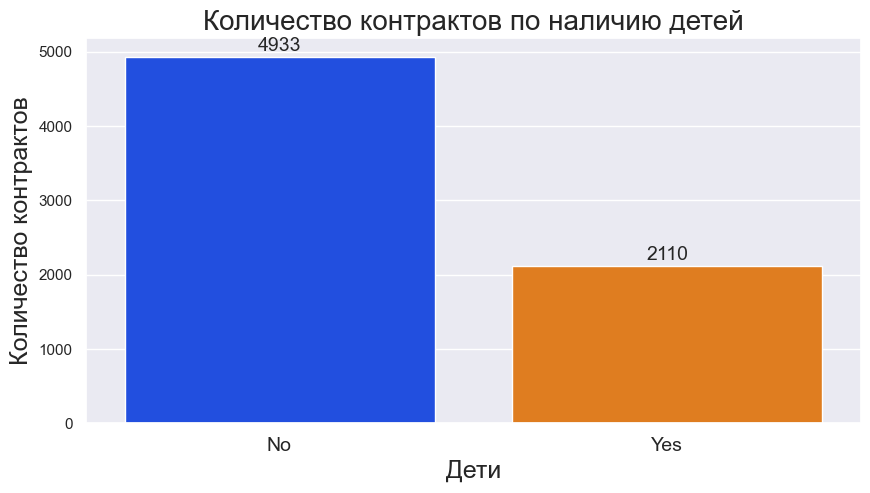

In [59]:
barplot_drow(df_personal,
             x_ax='dependents',
             figsize=(10, 5),
             group_by=True,
             col_to_aggregate='customer_id',
             title_plot='Количество контрактов по наличию детей',
             x_label='Дети',
             y_label='Количество контрактов')

Бездетных почти в 2.5 раза больше.

#### Датасет `df_internet`

**Столбец `internet_service` -  тип подключения.**

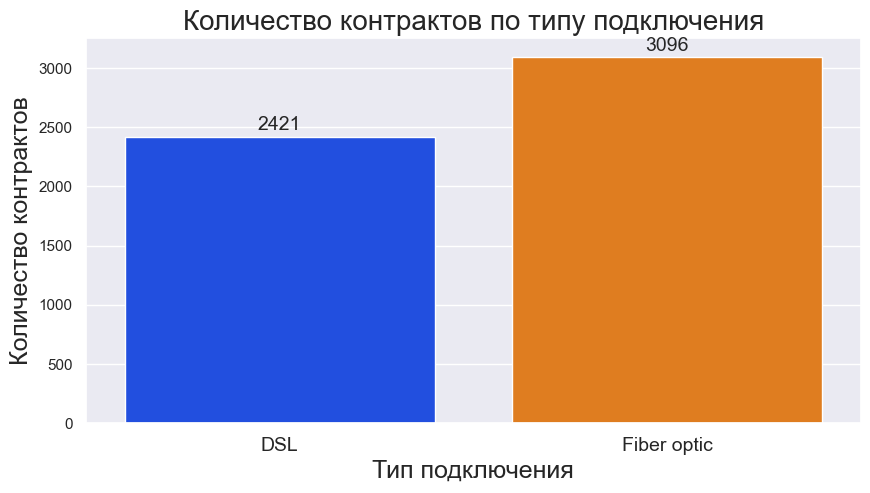

In [60]:
barplot_drow(df_internet,
             x_ax='internet_service',
             figsize=(10, 5),
             group_by=True,
             col_to_aggregate='customer_id',
             title_plot='Количество контрактов по типу подключения',
             x_label='Тип подключения',
             y_label='Количество контрактов')

Больше оптики, но `DSL` присутствует, видимо просто нет технической возможности проложить оптоволокно.

**Столбец `online_security` -  блокировка опасных сайтов.**

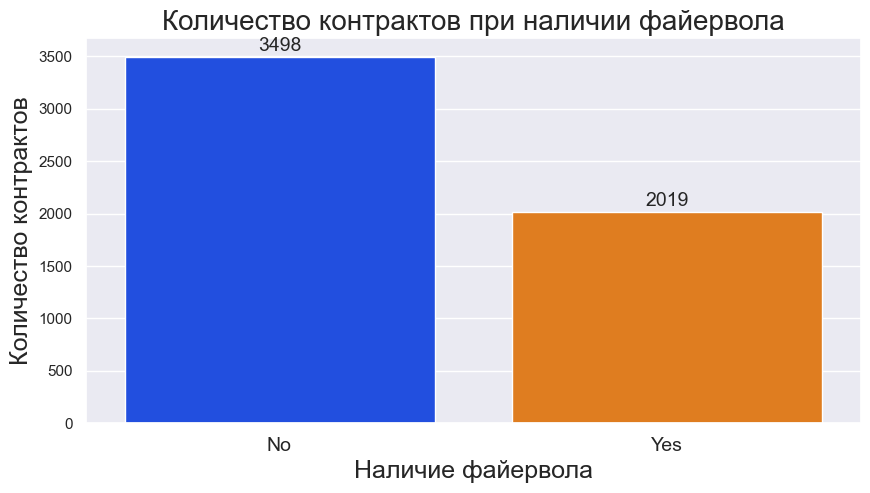

In [61]:
barplot_drow(df_internet,
             x_ax='online_security',
             figsize=(10, 5),
             group_by=True,
             col_to_aggregate='customer_id',
             title_plot='Количество контрактов при наличии файервола',
             x_label='Наличие файервола',
             y_label='Количество контрактов')

Хоть клиентов в файерволом и меньше, но они есть. Видимо не все полагаются лишь на свои силы.

**Столбец `online_backup` -  облачное хранилище файлов для резервного копирования данных.**

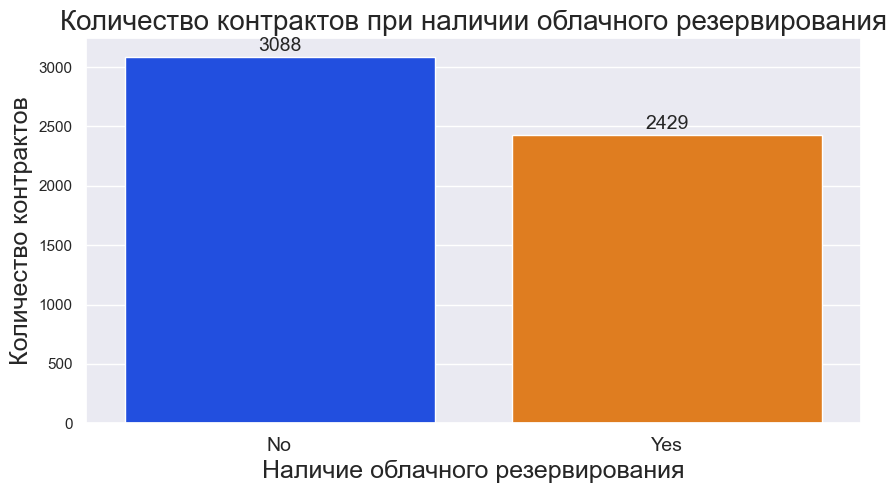

In [62]:
barplot_drow(
    df_internet,
    x_ax='online_backup',
    figsize=(10, 5),
    group_by=True,
    col_to_aggregate='customer_id',
    title_plot='Количество контрактов при наличии облачного резервирования',
    x_label='Наличие облачного резервирования',
    y_label='Количество контрактов')

Здесь виден уже более сознательных подход к резервированию, но все равно их меньше...

**Столбец `device_protection` -  антивирус.**

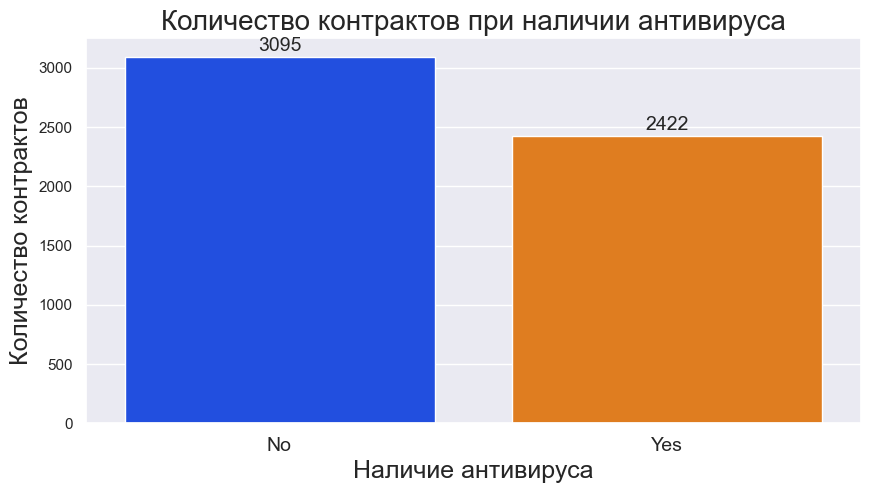

In [63]:
barplot_drow(df_internet,
             x_ax='device_protection',
             figsize=(10, 5),
             group_by=True,
             col_to_aggregate='customer_id',
             title_plot='Количество контрактов при наличии антивируса',
             x_label='Наличие антивируса',
             y_label='Количество контрактов')

С антивирусом аналогично резервированию.

**Столбец `tech_support` -  выделенная линия технической поддержки.**

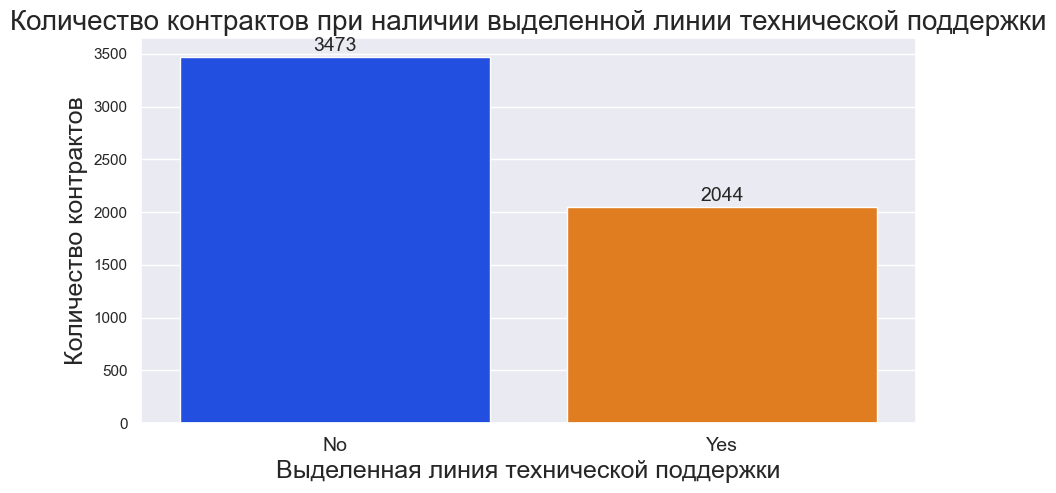

In [64]:
barplot_drow(
    df_internet,
    x_ax='tech_support',
    figsize=(10, 5),
    group_by=True,
    col_to_aggregate='customer_id',
    title_plot=
    'Количество контрактов при наличии выделенной линии технической поддержки',
    x_label='Выделенная линия технической поддержки',
    y_label='Количество контрактов')

На техподдержку рассчитывают далеко не все, как покажет практика - зря..

**Столбцы `streaming_tv` и `streaming_movies` -  стриминговое телевидение и каталог фильмов.**

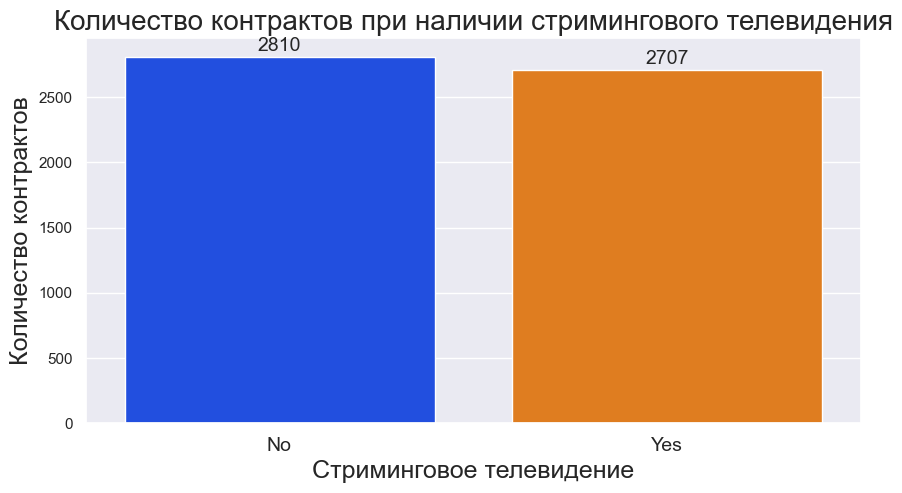

In [65]:
barplot_drow(
    df_internet,
    x_ax='streaming_tv',
    figsize=(10, 5),
    group_by=True,
    col_to_aggregate='customer_id',
    title_plot='Количество контрактов при наличии стримингового телевидения',
    x_label='Стриминговое телевидение',
    y_label='Количество контрактов')

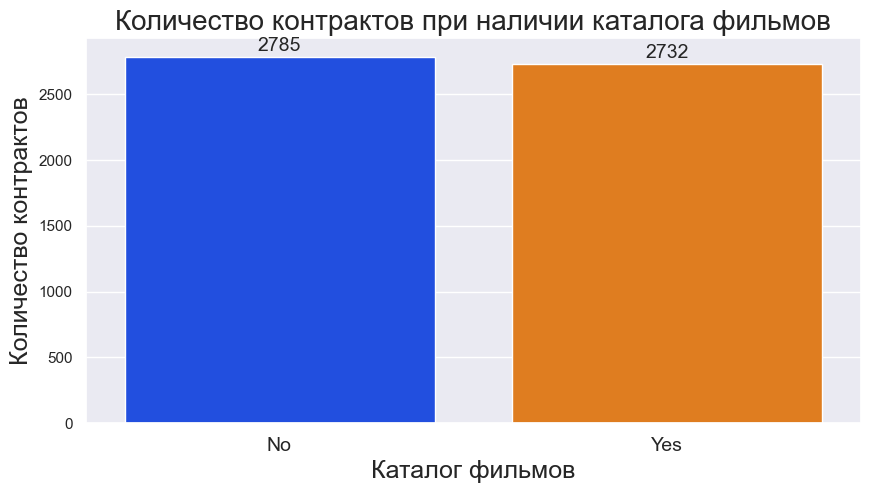

In [66]:
barplot_drow(df_internet,
             x_ax='streaming_movies',
             figsize=(10, 5),
             group_by=True,
             col_to_aggregate='customer_id',
             title_plot='Количество контрактов при наличии каталога фильмов',
             x_label='Каталог фильмов',
             y_label='Количество контрактов')

По телевидению и фильмам приблизительно пополам.

#### Датасет `df_phone`

**Столбец `multiple_lines` -  подключение телефона к нескольким линиям одновременно.**

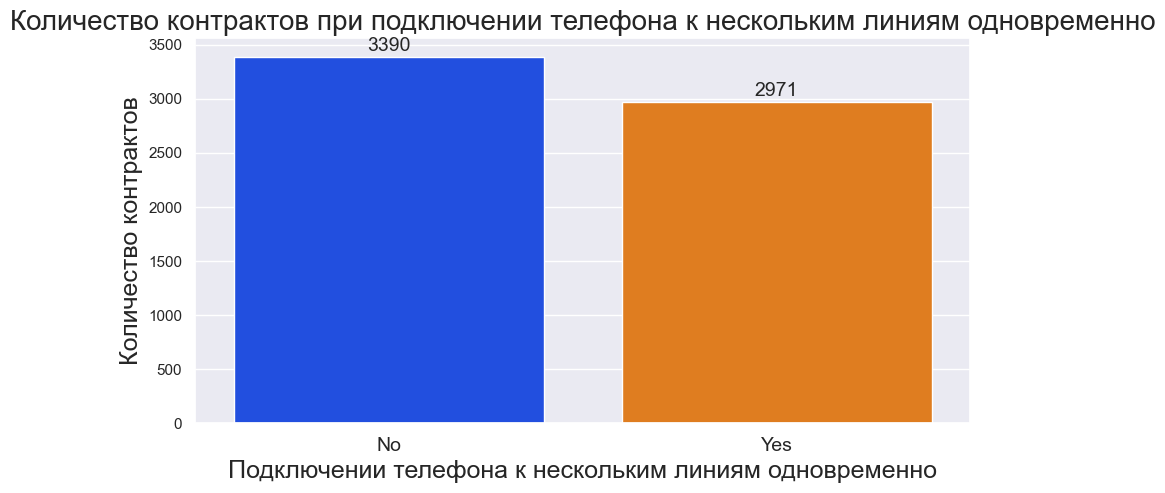

In [67]:
barplot_drow(
    df_phone,
    x_ax='multiple_lines',
    figsize=(10, 5),
    group_by=True,
    col_to_aggregate='customer_id',
    title_plot=
    'Количество контрактов при подключении телефона к нескольким линиям одновременно',
    x_label='Подключении телефона к нескольким линиям одновременно',
    y_label='Количество контрактов')

Почти половина пользуется многоканальным телефоном. Возможно для работы приходится использовать.

**Промежуточный вывод.**

Подводя итоги анализа признаков по четырём датасетам можно подвести некоторые итоги для общего понимания пользованиями услугами.

Все в принципе стандартно:

- от пола не зависит,
- холостых чуть больше,
- в основном без детей,
- работающие,

Больше используют оптику, без файервола, бэкапа и тех. поддержки.

### Объединение датасетов

**Объединение при помощи `reduce` по `customer_id`.**

In [68]:
frames = [df_personal, df_contract, df_phone, df_internet]

data = reduce(
    lambda left, right: pd.merge(left, right, on=['customer_id'], how='left'),
    frames)

del frames

**Информация по объединенному датасету.** 

In [69]:
display_dataset_info(data)

,customer_id,gender,senior_citizen,partner,dependents,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,duration,multiple_lines,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies
0,7590-VHVEG,Female,No,Yes,No,2019-04-29,NaT,Month-to-month,Yes,Electronic check,29.85,298.5,10,NaN,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,Male,No,No,No,2019-03-26,NaT,One year,No,Mailed check,56.95,683.4,11,No,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,Male,No,No,No,2018-08-09,2019-12-01,Month-to-month,Yes,Mailed check,53.85,861.6,16,No,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,Male,No,No,No,2018-12-22,NaT,One year,No,Bank transfer (automatic),42.30,1015.2,14,NaN,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Female,No,No,No,2019-01-26,2019-11-01,Month-to-month,Yes,Electronic check,70.70,707.0,10,No,Fiber optic,No,No,No,No,No,No



<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   customer_id        7043 non-null   object        
 1   gender             7043 non-null   object        
 2   senior_citizen     7043 non-null   object        
 3   partner            7043 non-null   object        
 4   dependents         7043 non-null   object        
 5   begin_date         7043 non-null   datetime64[ns]
 6   end_date           1869 non-null   datetime64[ns]
 7   type               7043 non-null   object        
 8   paperless_billing  7043 non-null   object        
 9   payment_method     7043 non-null   object        
 10  monthly_charges    7043 non-null   float64       
 11  total_charges      7043 non-null   float64       
 12  duration           7043 non-null   int64         
 13  multiple_lines     6361 non-null   object        
 14  interne

В результате объединения образовались пропуски в данных.

Это связано с тем, что не все пользуются интернетом и телефонными линиями.

Пропуски можно заполнить следующим образом:

- после объединения образовался пропуск в столбце `internet_service`: пропуск это означает, что нету интернета, есть только телефон. Заполним как `Only phone`,

- после объединения образовался пропуск в столбце `multiple_lines`: пропуск это означает, что нету телефона, есть только интернет. Заполним как `Only internet`,

- оставшиеся пропуски в столбцах по варианту `internet_service`:  `online_security`, `online_backup`, `device_protection`, `tech_support`, `streaming_tv`, `streaming_movies` заполним как `No`. 

In [70]:
data['internet_service'] = data['internet_service'].fillna('Only phone')
data['multiple_lines'] = data['multiple_lines'].fillna('Only internet')

data[[
    'online_security', 'online_backup', 'device_protection', 'tech_support',
    'streaming_tv', 'streaming_movies'
]] = data[[
    'online_security', 'online_backup', 'device_protection', 'tech_support',
    'streaming_tv', 'streaming_movies'
]].fillna('No')

### Целевой признак

Целевой признак будет выделен в столбец `target` на основании столбца `end_date`.

- если `end_date` пустое поле, то контракт действющий - `target` - `0`,
- если `end_date` не пустое поле, то контракт расторгнут - `target` - `1`,

In [71]:
tqdm.pandas(desc="Целевой признак")
data['target'] = data.progress_apply(lambda x: 0
                                     if pd.isnull(x['end_date']) else 1,
                                     axis=1)

Целевой признак: 100%|██████████| 7043/7043 [00:00<00:00, 60414.93it/s]


In [72]:
data.sample(5)

,customer_id,gender,senior_citizen,partner,dependents,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,duration,multiple_lines,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,target
4705,5760-FXFVO,Male,No,No,No,2019-03-30,NaT,Month-to-month,Yes,Electronic check,78.95,868.45,11,No,Fiber optic,Yes,Yes,No,No,No,No,0
466,9076-AXYIK,Male,Yes,Yes,No,2019-03-17,NaT,Two year,No,Electronic check,102.10,2450.40,11,Yes,Fiber optic,No,No,Yes,Yes,Yes,Yes,0
5949,8756-RDDLT,Female,No,No,No,2019-04-10,NaT,Month-to-month,No,Electronic check,44.95,449.50,10,Only internet,DSL,No,Yes,No,Yes,No,Yes,0
181,6582-OIVSP,Female,No,No,No,2019-06-22,NaT,Month-to-month,No,Mailed check,45.30,362.40,8,No,DSL,No,No,No,No,No,No,0
4481,8644-XYTSV,Male,No,Yes,No,2019-05-17,NaT,Month-to-month,Yes,Bank transfer (automatic),40.15,361.35,9,Only internet,DSL,Yes,No,No,No,Yes,No,0


### Исследовательский анализ данных объединённой таблицы

Сначала проведем анализ оттока в зависимости от категориальных признаков.

**Столбец `gender` - пол.**

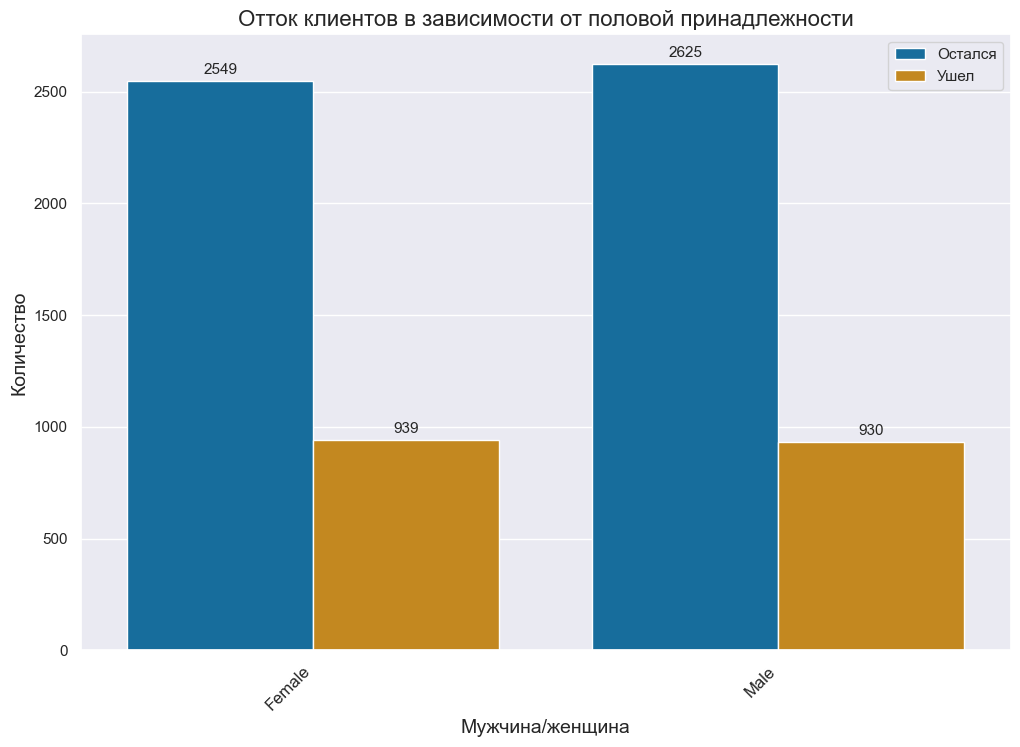

In [73]:
countplot_drow(
    data,
    x_ax='gender',
    hue='target',
    figsize=(12, 8),
    font_xtick=12,
    size_annot=11,
    color_palette='colorblind',
    title_plot='Отток клиентов в зависимости от половой принадлежности',
    x_label='Мужчина/женщина',
    y_label='Количество',
    title_font_size=16,
    xlabel_font_size=14,
    ylabel_font_size=14,
    hue_legend_list=['Остался', 'Ушел'])

Тут все пополам. От половой принадлежности отток не зависит.

**Столбец `senior_citizen` - является ли абонент пенсионером.**

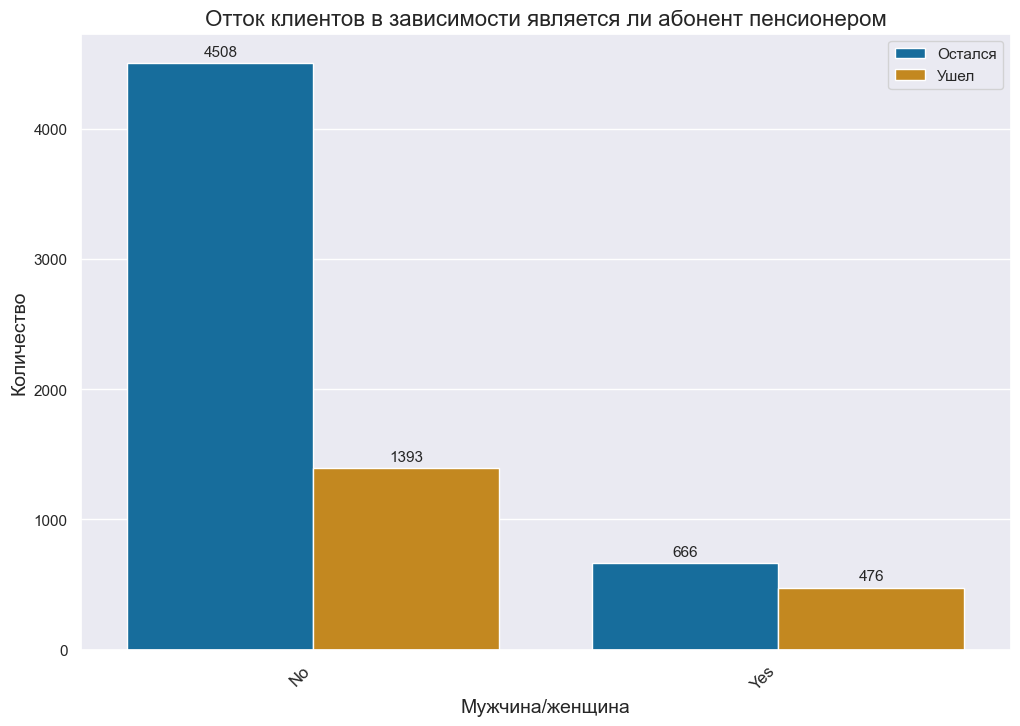

In [74]:
countplot_drow(
    data,
    x_ax='senior_citizen',
    hue='target',
    figsize=(12, 8),
    font_xtick=12,
    size_annot=11,
    color_palette='colorblind',
    title_plot='Отток клиентов в зависимости является ли абонент пенсионером',
    x_label='Мужчина/женщина',
    y_label='Количество',
    title_font_size=16,
    xlabel_font_size=14,
    ylabel_font_size=14,
    hue_legend_list=['Остался', 'Ушел'])

Как видим отток среди пенсионеров больше в пропорциях нежели у работающих.

**Столбец `partner` - есть ли у абонента супруг или супруга.**

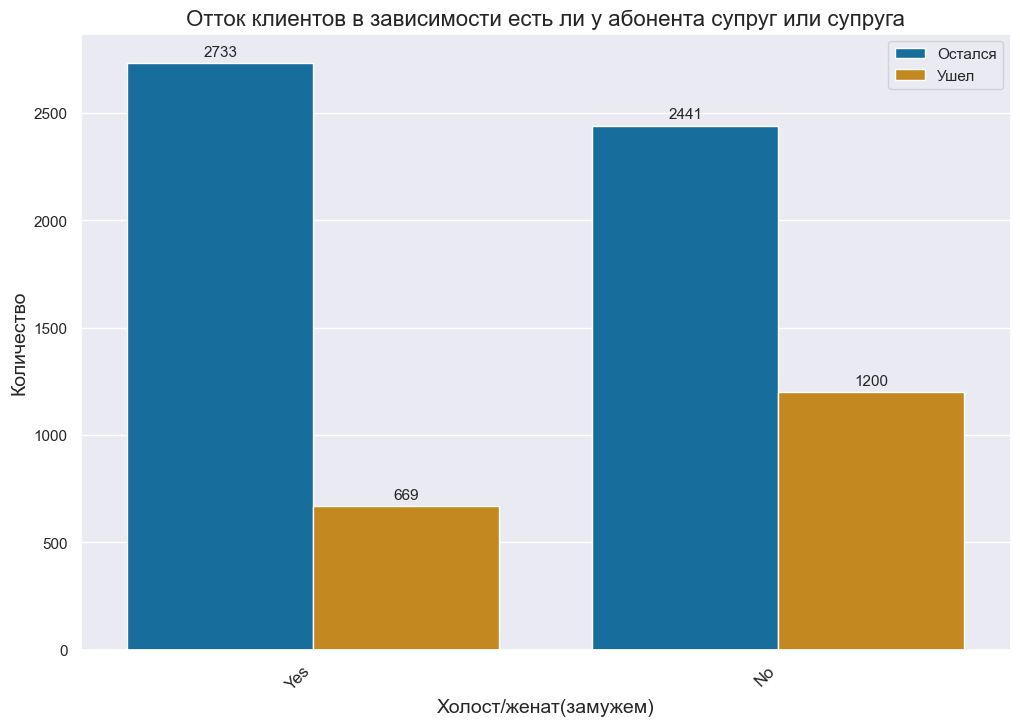

In [75]:
countplot_drow(
    data,
    x_ax='partner',
    hue='target',
    figsize=(12, 8),
    font_xtick=12,
    size_annot=11,
    color_palette='colorblind',
    title_plot=
    'Отток клиентов в зависимости есть ли у абонента супруг или супруга',
    x_label='Холост/женат(замужем)',
    y_label='Количество',
    title_font_size=16,
    xlabel_font_size=14,
    ylabel_font_size=14,
    hue_legend_list=['Остался', 'Ушел'])

У холостых отток в проборциях больше..

**Столбец `dependents` - есть ли у абонента дети.**

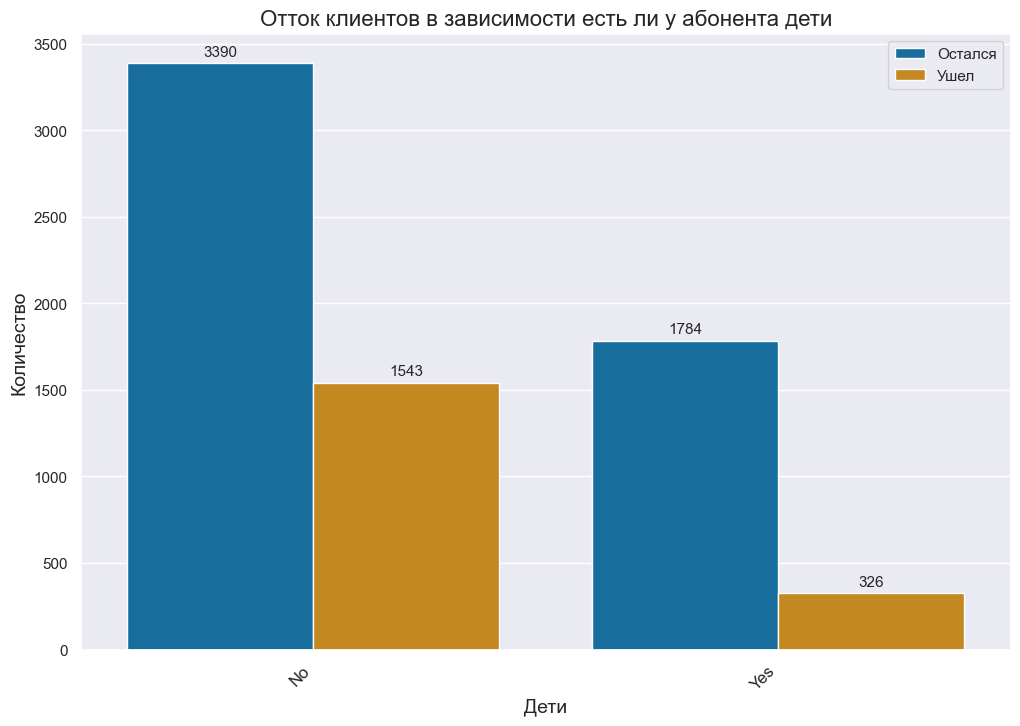

In [76]:
countplot_drow(
    data,
    x_ax='dependents',
    hue='target',
    figsize=(12, 8),
    font_xtick=12,
    size_annot=11,
    color_palette='colorblind',
    title_plot='Отток клиентов в зависимости есть ли у абонента дети',
    x_label='Дети',
    y_label='Количество',
    title_font_size=16,
    xlabel_font_size=14,
    ylabel_font_size=14,
    hue_legend_list=['Остался', 'Ушел'])

С детьми уходят меньше, чем без детей..

**Столбец `type` - тип оплаты: раз в год-два или ежемесячно.**

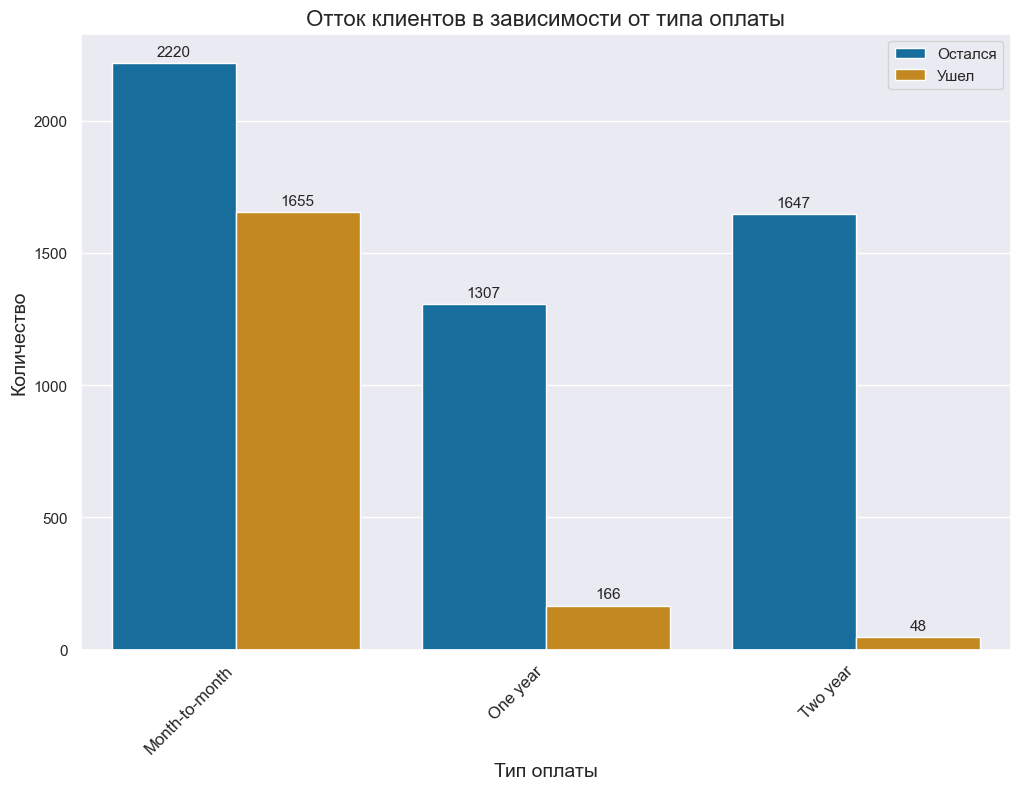

In [77]:
countplot_drow(data,
               x_ax='type',
               hue='target',
               figsize=(12, 8),
               font_xtick=12,
               size_annot=11,
               color_palette='colorblind',
               title_plot='Отток клиентов в зависимости от типа оплаты',
               x_label='Тип оплаты',
               y_label='Количество',
               title_font_size=16,
               xlabel_font_size=14,
               ylabel_font_size=14,
               hue_legend_list=['Остался', 'Ушел'])

Тут все логично. Долгосрочники уходят значительно реже нежели при помесячной оплате.

**Столбец `paperless_billing` - электронный расчётный лист.**

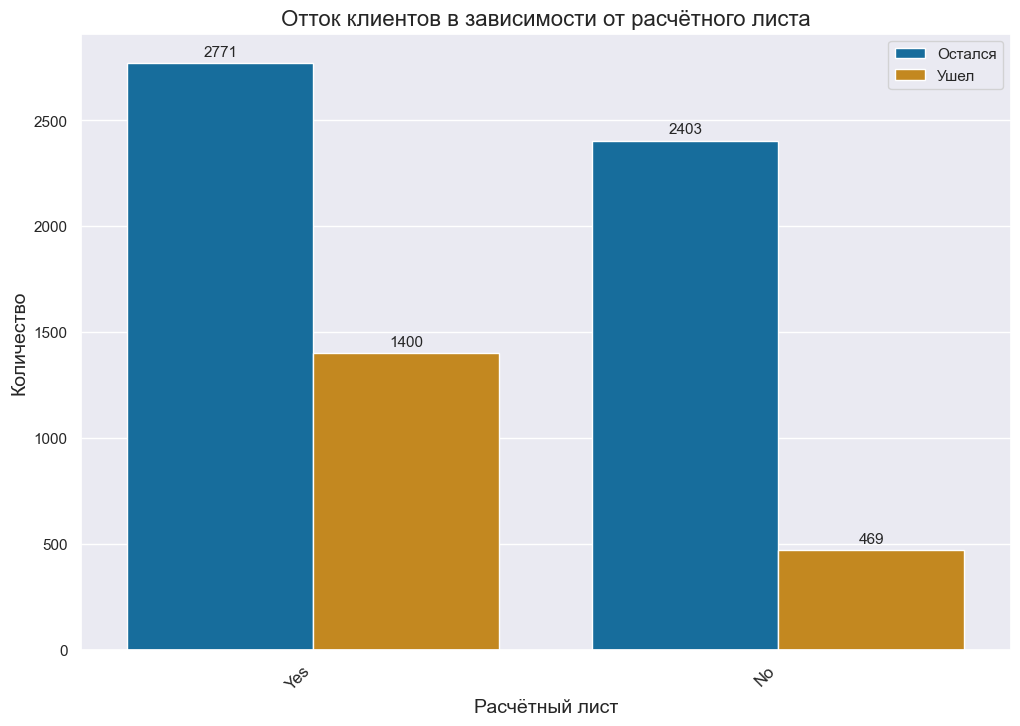

In [78]:
countplot_drow(data,
               x_ax='paperless_billing',
               hue='target',
               figsize=(12, 8),
               font_xtick=12,
               size_annot=11,
               color_palette='colorblind',
               title_plot='Отток клиентов в зависимости от расчётного листа',
               x_label='Расчётный лист',
               y_label='Количество',
               title_font_size=16,
               xlabel_font_size=14,
               ylabel_font_size=14,
               hue_legend_list=['Остался', 'Ушел'])

С бумажным документооборотом уходят меньше.

**Столбец `payment_method` - тип платежа.**

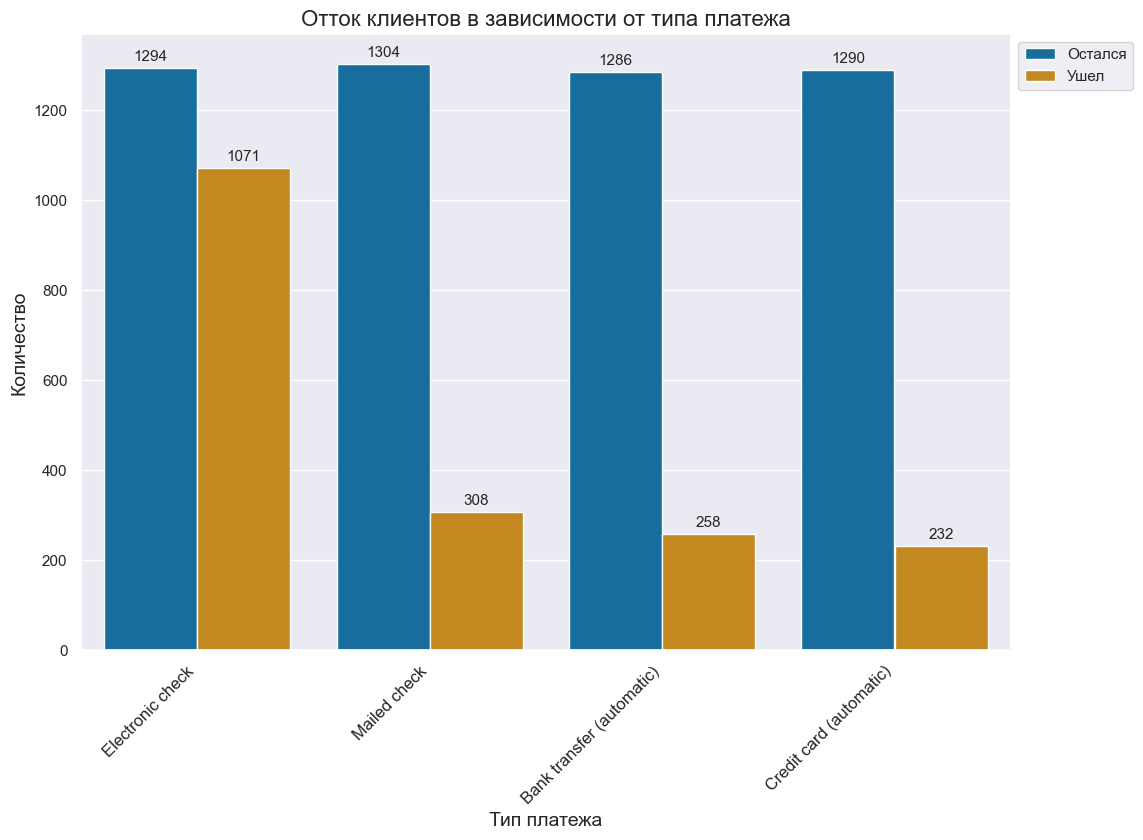

In [79]:
countplot_drow(data,
               x_ax='payment_method',
               hue='target',
               figsize=(12, 8),
               font_xtick=12,
               size_annot=11,
               color_palette='colorblind',
               title_plot='Отток клиентов в зависимости от типа платежа',
               x_label='Тип платежа',
               y_label='Количество',
               title_font_size=16,
               xlabel_font_size=14,
               ylabel_font_size=14,
               hue_legend_list=['Остался', 'Ушел'])

Наибольший отток при электронных платежах. Остальные приблизительно равны. 

**Столбец `internet_service` -  тип подключения.**

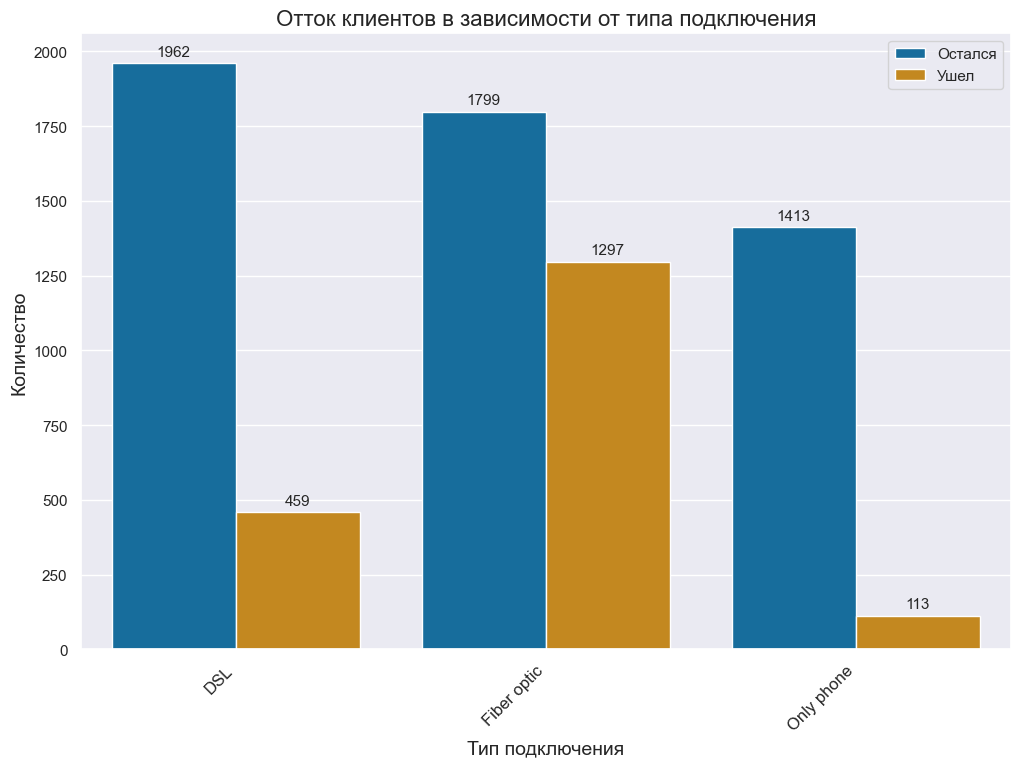

In [80]:
countplot_drow(data,
               x_ax='internet_service',
               hue='target',
               figsize=(12, 8),
               font_xtick=12,
               size_annot=11,
               color_palette='colorblind',
               title_plot='Отток клиентов в зависимости от типа подключения',
               x_label='Тип подключения',
               y_label='Количество',
               title_font_size=16,
               xlabel_font_size=14,
               ylabel_font_size=14,
               hue_legend_list=['Остался', 'Ушел'])

Видим основной отток у оптики.

А вот далее можно проанализировать вглубь.

Исходя из самого большого оттока у месячных контрактов и оптических каналов можно пройтись по опциям с наибольшим оттоком.

**Отток месячных контрактов на оптике при наличии/отсутствии техподдержки.**

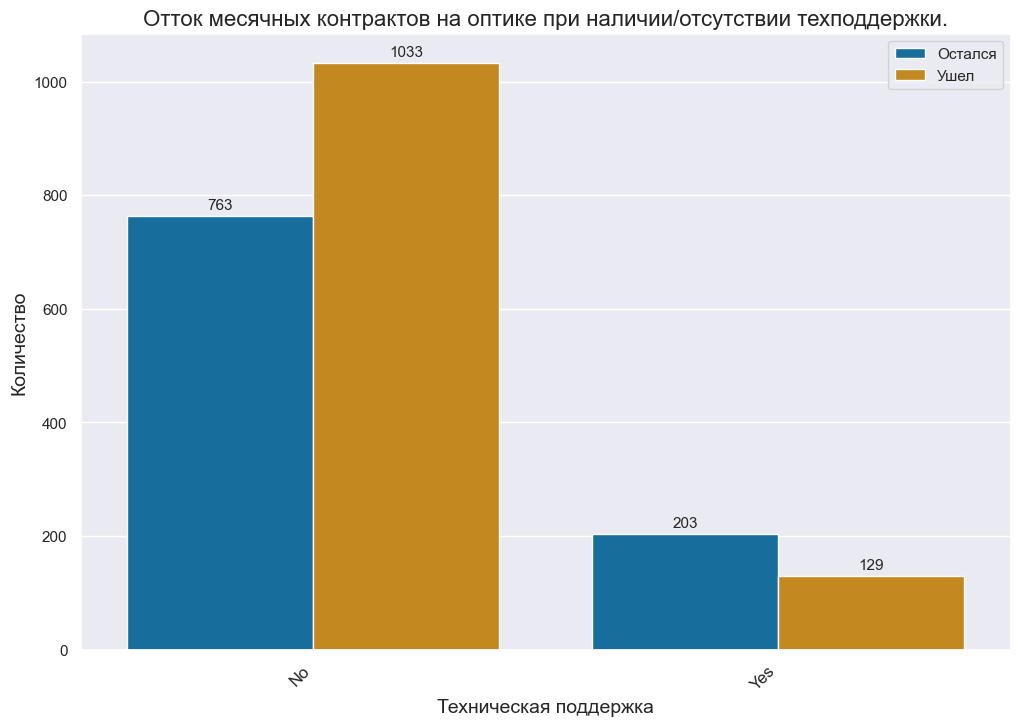

In [81]:
countplot_drow(
    data[(data['type'] == 'Month-to-month')
         & (data['internet_service'] == 'Fiber optic')],
    x_ax='tech_support',
    hue='target',
    figsize=(12, 8),
    font_xtick=12,
    size_annot=11,
    color_palette='colorblind',
    title_plot=
    'Отток месячных контрактов на оптике при наличии/отсутствии техподдержки.',
    x_label='Техническая поддержка',
    y_label='Количество',
    title_font_size=16,
    xlabel_font_size=14,
    ylabel_font_size=14,
    hue_legend_list=['Остался', 'Ушел'])

Вот тут уже видим что без тех.поддержки на оптике никуда....

Далее движемся вглубь при отсутсвии тех.поддержки и с её наличием.

**Файервол при контракте на месяц, на оптике при отсутствии тех.поддержки.**

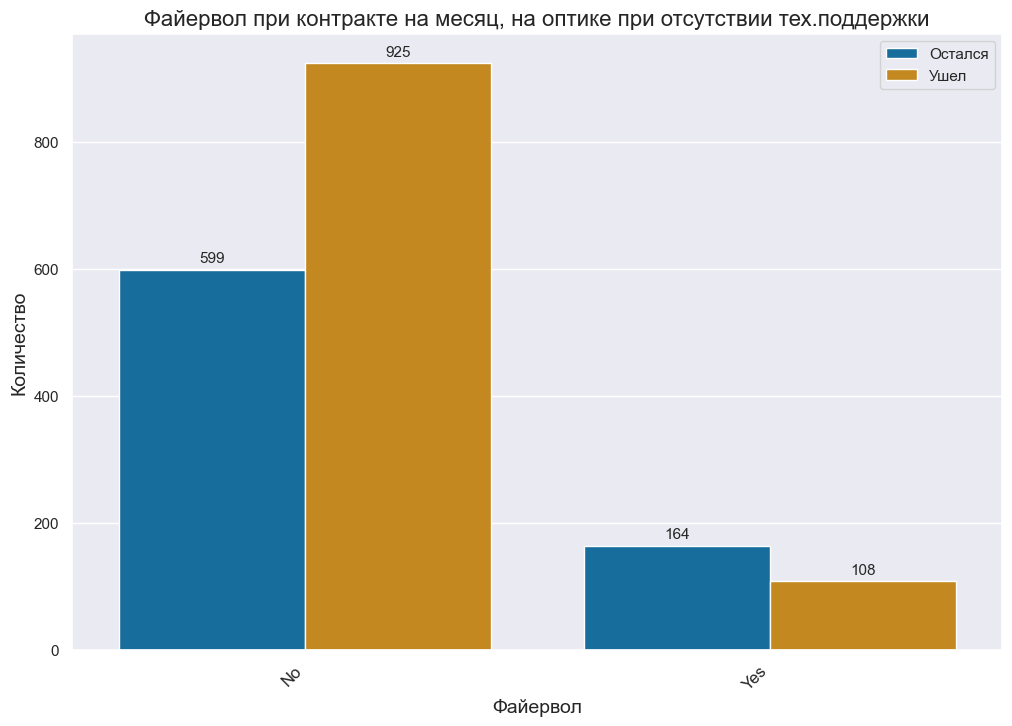

In [82]:
countplot_drow(
    data[(data['type'] == 'Month-to-month')
         & (data['internet_service'] == 'Fiber optic') &
         (data['tech_support'] == 'No')],
    x_ax='online_security',
    hue='target',
    figsize=(12, 8),
    font_xtick=12,
    size_annot=11,
    color_palette='colorblind',
    title_plot=
    'Файервол при контракте на месяц, на оптике при отсутствии тех.поддержки',
    x_label='Файервол',
    y_label='Количество',
    title_font_size=16,
    xlabel_font_size=14,
    ylabel_font_size=14,
    hue_legend_list=['Остался', 'Ушел'])

Опять же тех.поддержка сильно влияет на отток.

**Файервол при контракте на месяц, на оптике при наличии тех.поддержки.**

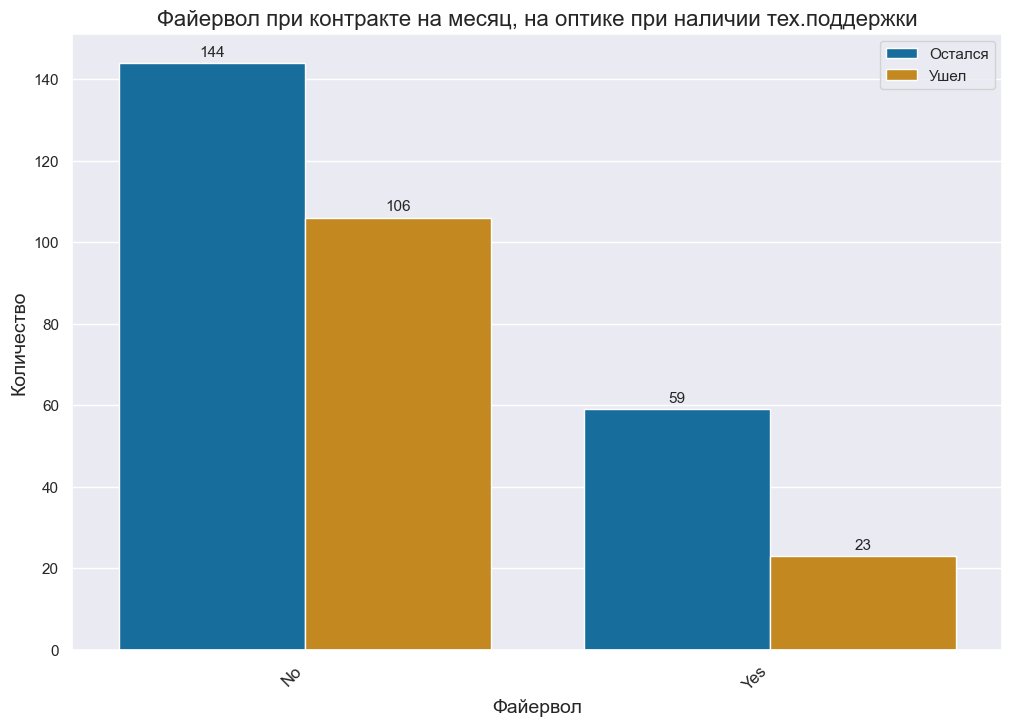

In [83]:
countplot_drow(
    data[(data['type'] == 'Month-to-month')
         & (data['internet_service'] == 'Fiber optic') &
         (data['tech_support'] == 'Yes')],
    x_ax='online_security',
    hue='target',
    figsize=(12, 8),
    font_xtick=12,
    size_annot=11,
    color_palette='colorblind',
    title_plot=
    'Файервол при контракте на месяц, на оптике при наличии тех.поддержки',
    x_label='Файервол',
    y_label='Количество',
    title_font_size=16,
    xlabel_font_size=14,
    ylabel_font_size=14,
    hue_legend_list=['Остался', 'Ушел'])

А вот здесь видно, что с тех поддержкой ситуация иная.

**Облачный резерв при контракте на месяц, на оптике при отсутствии тех.поддержки.**

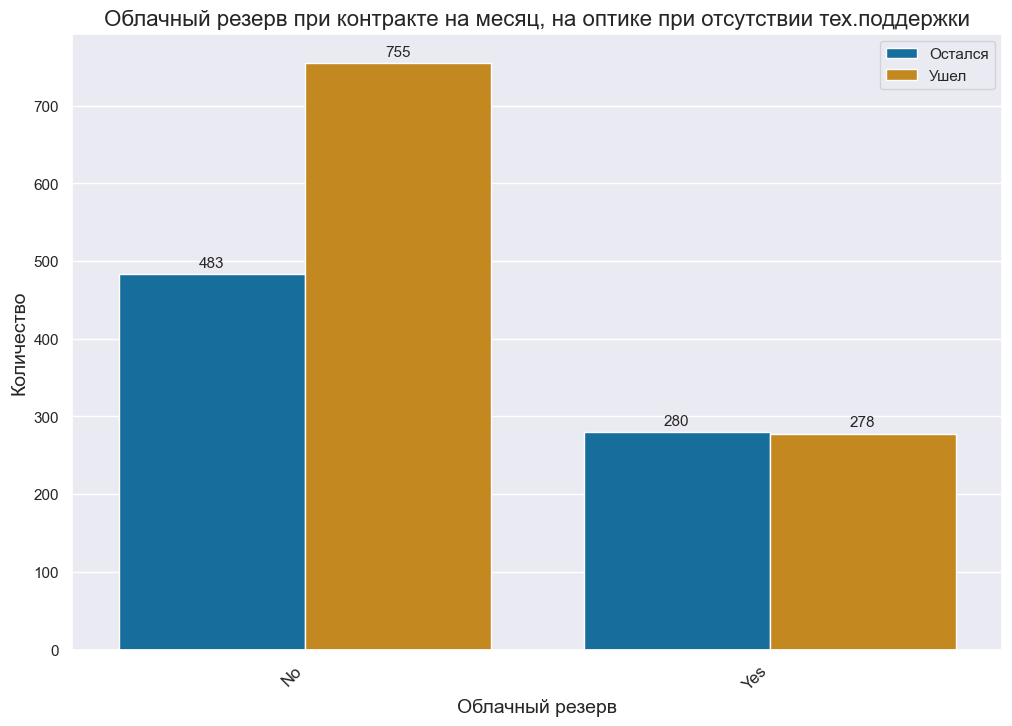

In [84]:
countplot_drow(
    data[(data['type'] == 'Month-to-month')
         & (data['internet_service'] == 'Fiber optic') &
         (data['tech_support'] == 'No')],
    x_ax='online_backup',
    hue='target',
    figsize=(12, 8),
    font_xtick=12,
    size_annot=11,
    color_palette='colorblind',
    title_plot=
    'Облачный резерв при контракте на месяц, на оптике при отсутствии тех.поддержки',
    x_label='Облачный резерв',
    y_label='Количество',
    title_font_size=16,
    xlabel_font_size=14,
    ylabel_font_size=14,
    hue_legend_list=['Остался', 'Ушел'])

**Облачный резерв при контракте на месяц, на оптике при наличии тех.поддержки.**

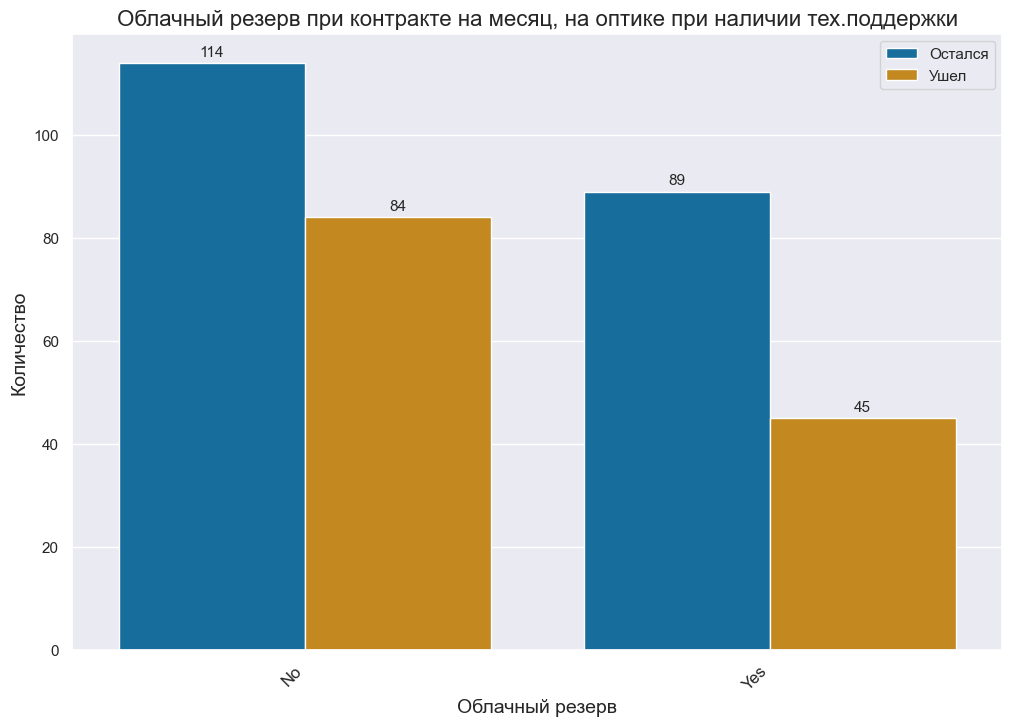

In [85]:
countplot_drow(
    data[(data['type'] == 'Month-to-month')
         & (data['internet_service'] == 'Fiber optic') &
         (data['tech_support'] == 'Yes')],
    x_ax='online_backup',
    hue='target',
    figsize=(12, 8),
    font_xtick=12,
    size_annot=11,
    color_palette='colorblind',
    title_plot=
    'Облачный резерв при контракте на месяц, на оптике при наличии тех.поддержки',
    x_label='Облачный резерв',
    y_label='Количество',
    title_font_size=16,
    xlabel_font_size=14,
    ylabel_font_size=14,
    hue_legend_list=['Остался', 'Ушел'])

Аналогично: c тех.поддержкой отток меньше.

**Столбцы `streaming_tv` и `streaming_movies` -  стриминговое телевидение и каталог фильмов при контракте на месяц, на оптике в зависимости от тех.поддержки.**

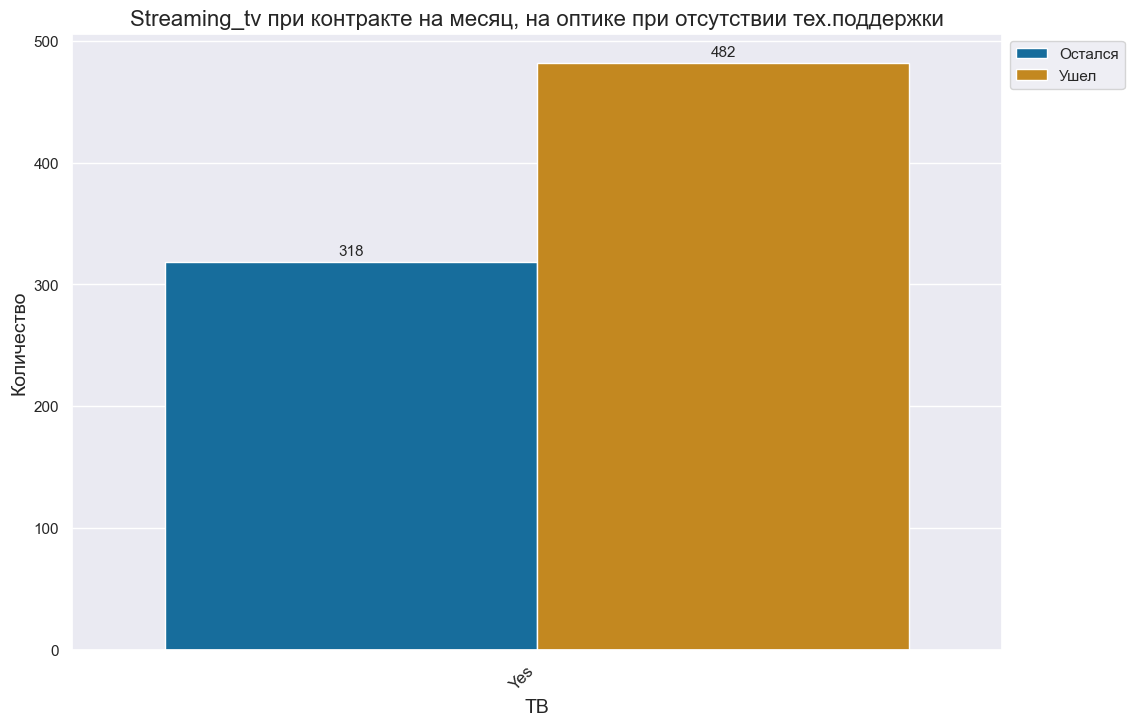

In [86]:
countplot_drow(
    data[(data['type'] == 'Month-to-month')
         & (data['internet_service'] == 'Fiber optic') &
         (data['tech_support'] == 'No') & (data['streaming_tv'] == 'Yes')],
    x_ax='streaming_tv',
    hue='target',
    figsize=(12, 8),
    font_xtick=12,
    size_annot=11,
    color_palette='colorblind',
    title_plot=
    'Streaming_tv при контракте на месяц, на оптике при отсутствии тех.поддержки',
    x_label='ТВ',
    y_label='Количество',
    title_font_size=16,
    xlabel_font_size=14,
    ylabel_font_size=14,
    hue_legend_list=['Остался', 'Ушел'])

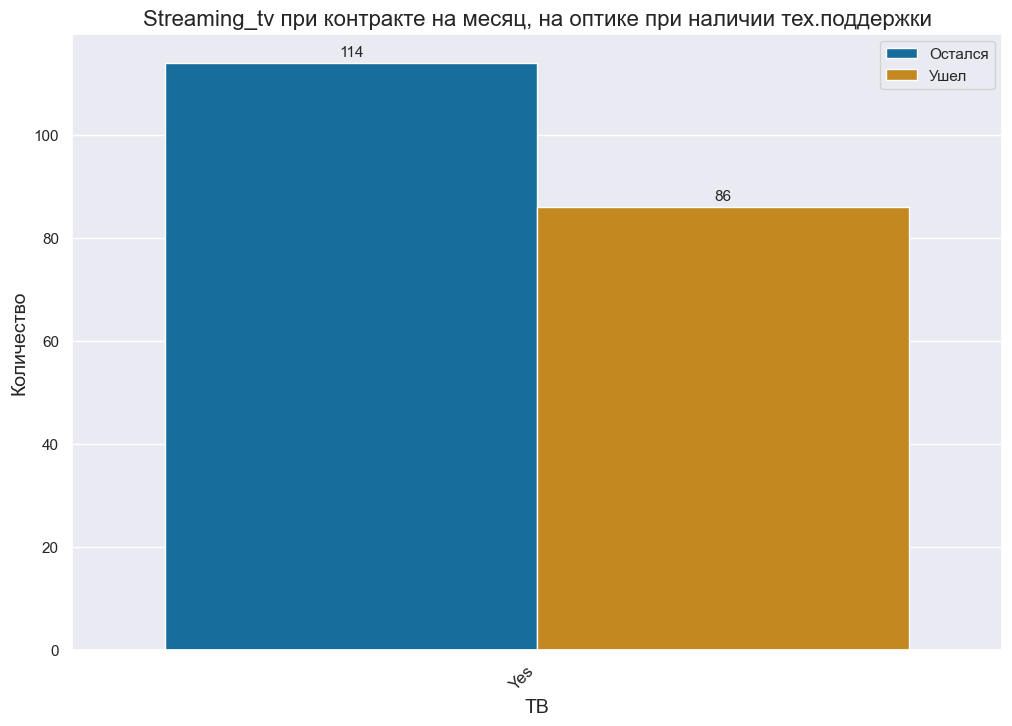

In [87]:
countplot_drow(
    data[(data['type'] == 'Month-to-month')
         & (data['internet_service'] == 'Fiber optic') &
         (data['tech_support'] == 'Yes') & (data['streaming_tv'] == 'Yes')],
    x_ax='streaming_tv',
    hue='target',
    figsize=(12, 8),
    font_xtick=12,
    size_annot=11,
    color_palette='colorblind',
    title_plot=
    'Streaming_tv при контракте на месяц, на оптике при наличии тех.поддержки',
    x_label='ТВ',
    y_label='Количество',
    title_font_size=16,
    xlabel_font_size=14,
    ylabel_font_size=14,
    hue_legend_list=['Остался', 'Ушел'])

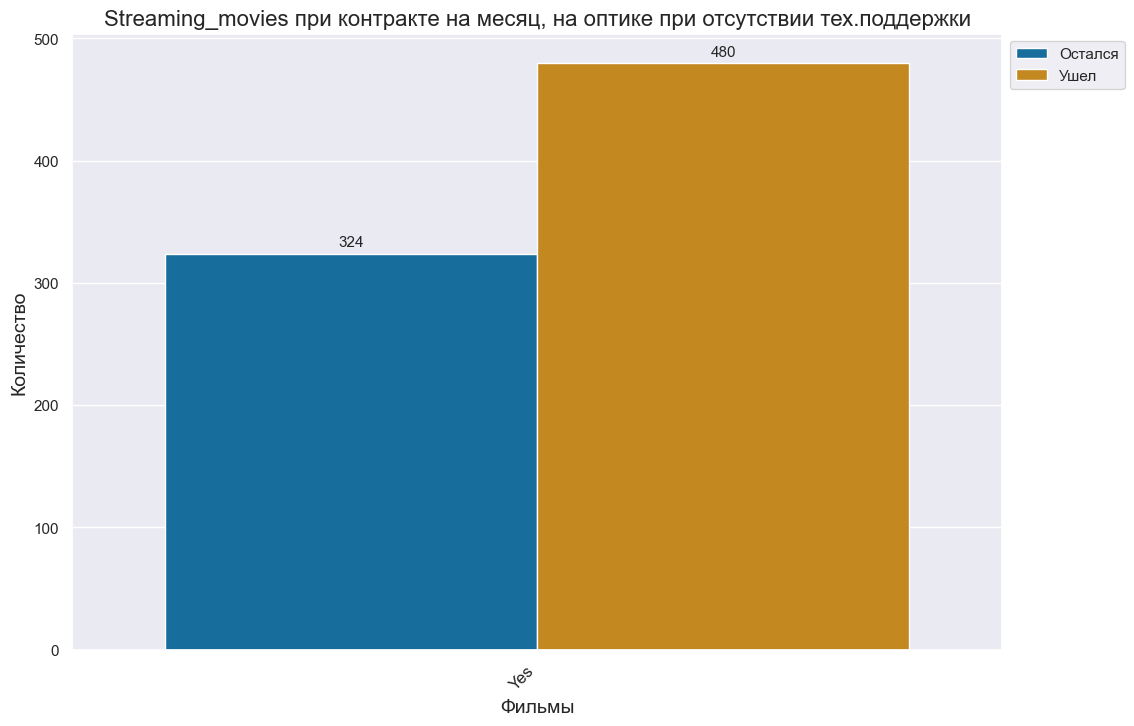

In [88]:
countplot_drow(
    data[(data['type'] == 'Month-to-month')
         & (data['internet_service'] == 'Fiber optic') &
         (data['tech_support'] == 'No') & (data['streaming_movies'] == 'Yes')],
    x_ax='streaming_movies',
    hue='target',
    figsize=(12, 8),
    font_xtick=12,
    size_annot=11,
    color_palette='colorblind',
    title_plot=
    'Streaming_movies при контракте на месяц, на оптике при отсутствии тех.поддержки',
    x_label='Фильмы',
    y_label='Количество',
    title_font_size=16,
    xlabel_font_size=14,
    ylabel_font_size=14,
    hue_legend_list=['Остался', 'Ушел'])

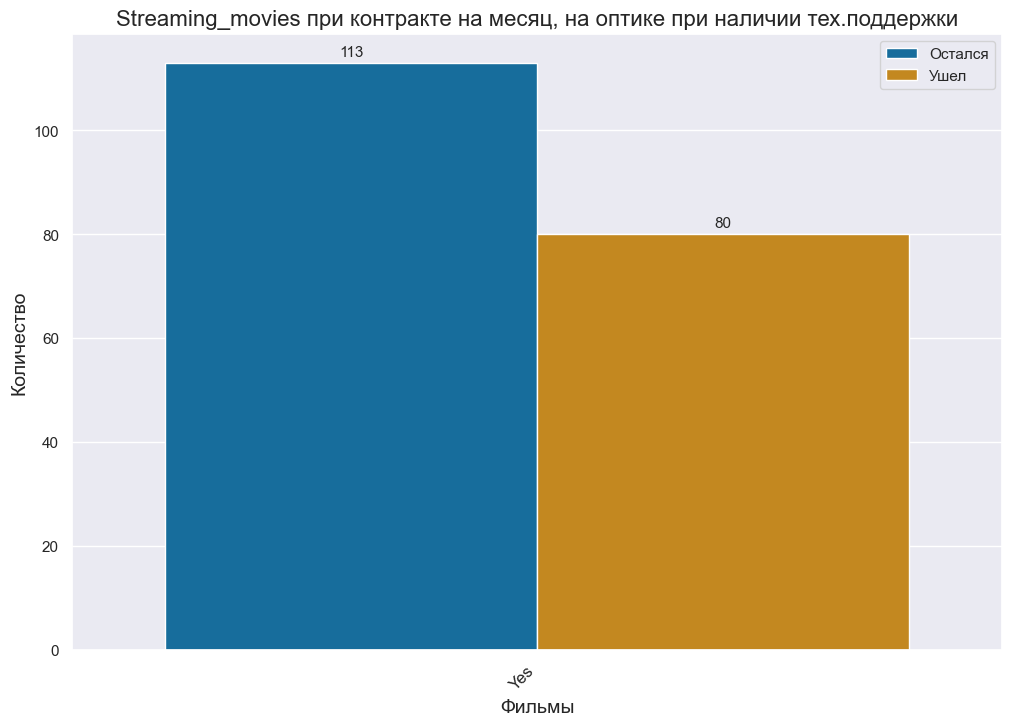

In [89]:
countplot_drow(
    data[(data['type'] == 'Month-to-month')
         & (data['internet_service'] == 'Fiber optic') &
         (data['tech_support'] == 'Yes') &
         (data['streaming_movies'] == 'Yes')],
    x_ax='streaming_movies',
    hue='target',
    figsize=(12, 8),
    font_xtick=12,
    size_annot=11,
    color_palette='colorblind',
    title_plot=
    'Streaming_movies при контракте на месяц, на оптике при наличии тех.поддержки',
    x_label='Фильмы',
    y_label='Количество',
    title_font_size=16,
    xlabel_font_size=14,
    ylabel_font_size=14,
    hue_legend_list=['Остался', 'Ушел'])

Судя по всему телевидение и фильмы на опптике у этого оператора впринципе плохие, но тех.поддержка немного спасае положение. 

**Столбец `multiple_lines` -  подключение телефона к нескольким линиям одновременно.**

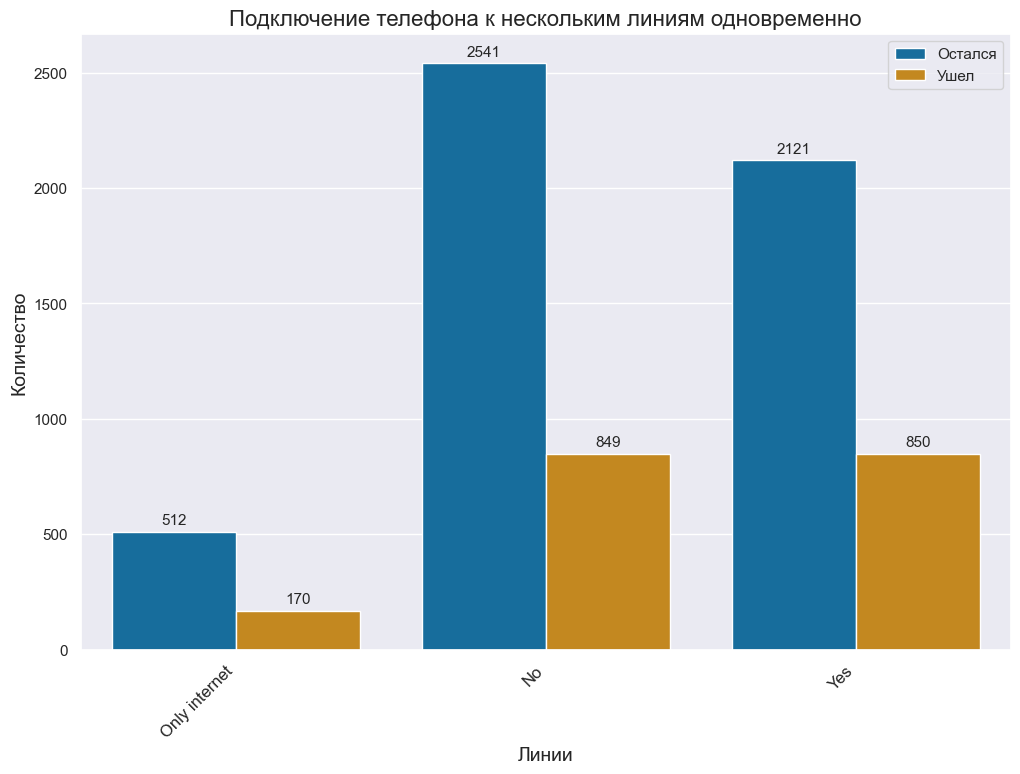

In [90]:
countplot_drow(
    data,
    x_ax='multiple_lines',
    hue='target',
    figsize=(12, 8),
    font_xtick=12,
    size_annot=11,
    color_palette='colorblind',
    title_plot='Подключение телефона к нескольким линиям одновременно',
    x_label='Линии',
    y_label='Количество',
    title_font_size=16,
    xlabel_font_size=14,
    ylabel_font_size=14,
    hue_legend_list=['Остался', 'Ушел'])

У многоканальных линий отток чуть больше чем у других.

Рассмотрим сезонность оттока в зависимости от месяца заключения контракта.

**Столбец с месяцем заключения контракта.** 

In [91]:
data['month'] = data['begin_date'].dt.month

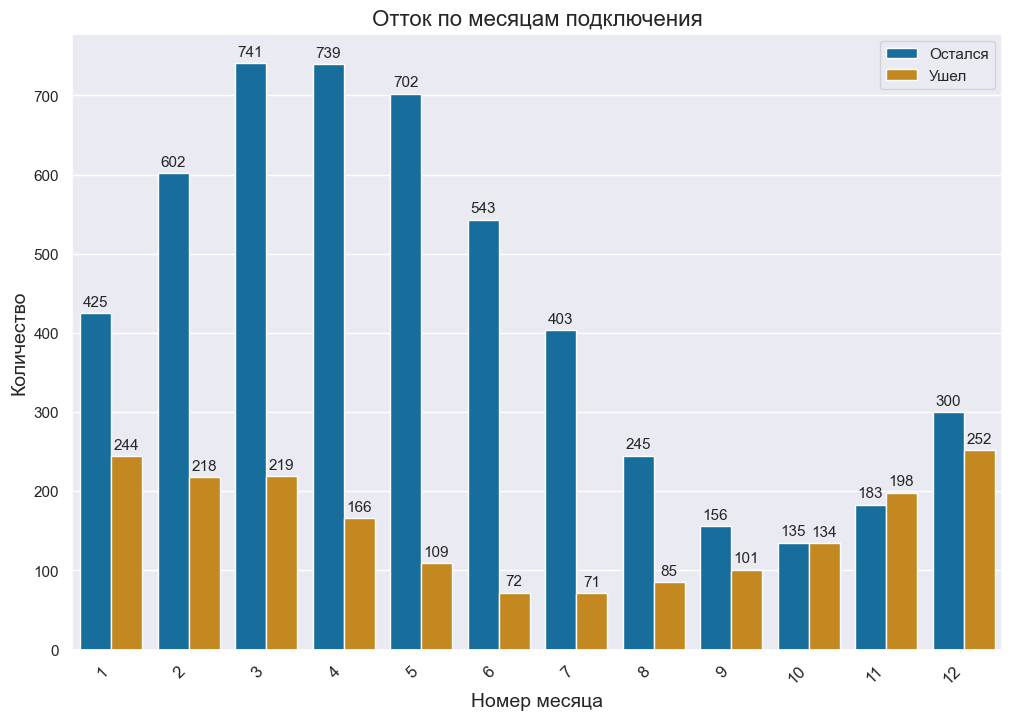

In [92]:
countplot_drow(data,
               x_ax='month',
               hue='target',
               figsize=(12, 8),
               font_xtick=12,
               size_annot=11,
               color_palette='colorblind',
               title_plot='Отток по месяцам подключения',
               x_label='Номер месяца',
               y_label='Количество',
               title_font_size=16,
               xlabel_font_size=14,
               ylabel_font_size=14,
               hue_legend_list=['Остался', 'Ушел'])

Октябрь, Ноябрь, Декабрь - достаточно высокий отток...

Т.к. уже есть 2 признака выделенных из столбца `begin_date` - это может привести к утечке данных.

Признак `duration` нужен был исключительно для выправления ценовых показателей. Его можно удалить.

In [93]:
del data['duration']

**Преобразование категориальных признаков к типу `category`.**

In [94]:
data[[
    'gender', 'senior_citizen', 'partner', 'dependents', 'type',
    'paperless_billing', 'payment_method', 'multiple_lines',
    'internet_service', 'online_security', 'online_backup',
    'device_protection', 'tech_support', 'streaming_tv', 'streaming_movies',
    'month'
]] = data[[
    'gender', 'senior_citizen', 'partner', 'dependents', 'type',
    'paperless_billing', 'payment_method', 'multiple_lines',
    'internet_service', 'online_security', 'online_backup',
    'device_protection', 'tech_support', 'streaming_tv', 'streaming_movies',
    'month'
]].astype('category')

### Корреляция между признаками и целевым признаком (`target`)

In [95]:
columns = [
    'gender', 'senior_citizen', 'partner', 'dependents', 'type',
    'paperless_billing', 'payment_method', 'monthly_charges', 'total_charges',
    'multiple_lines', 'internet_service', 'online_security', 'online_backup',
    'device_protection', 'tech_support', 'streaming_tv', 'streaming_movies',
    'target', 'month'
]

corr_matrix_cramer = pd.DataFrame()
for i in range(len(columns)):
    for j in range(len(columns)):
        corr_matrix_cramer.loc[columns[i], columns[j]] = cramers_v(
            data[columns[i]], data[columns[j]]).round(2)

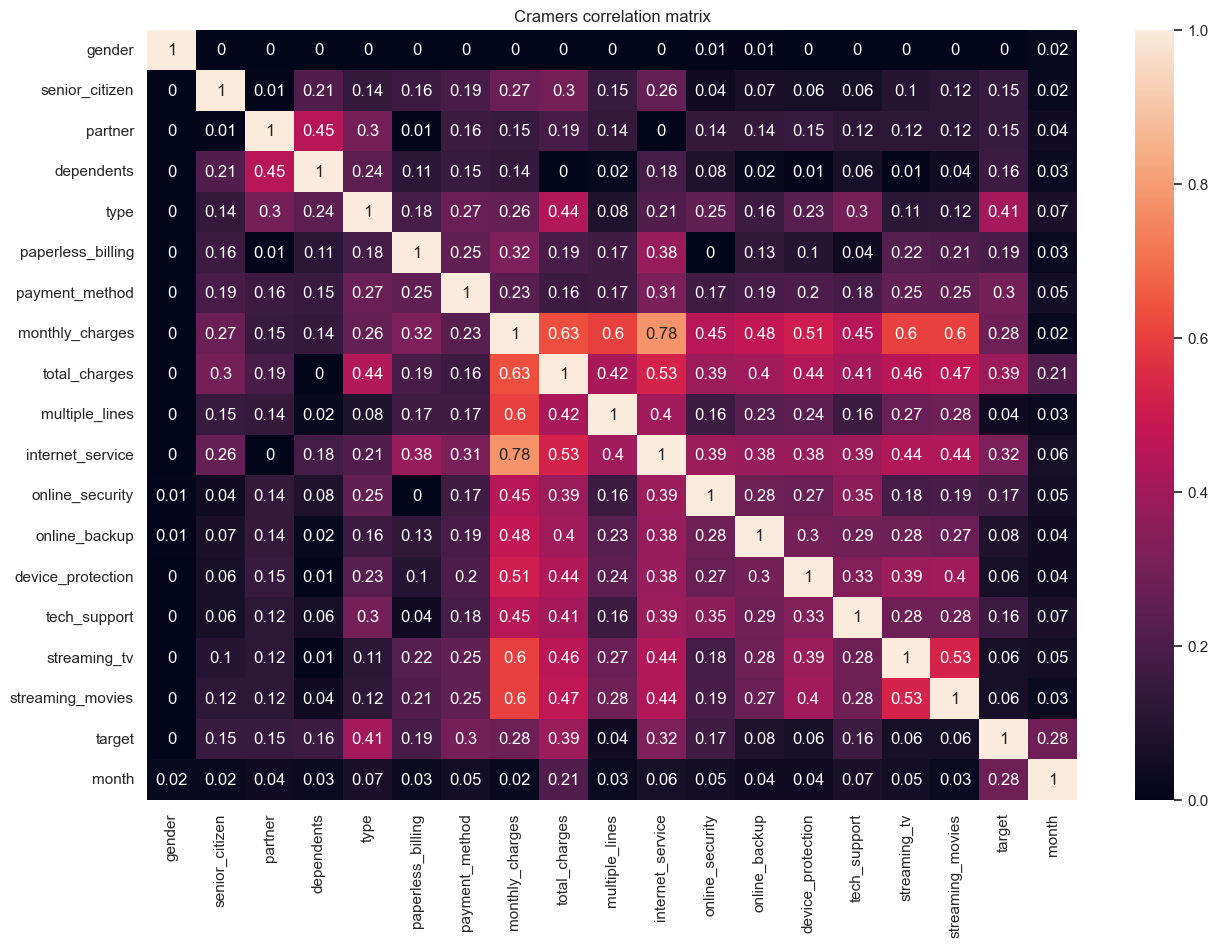

In [96]:
fig, ax = plt.subplots(figsize=(15,10))
sns.heatmap(data=corr_matrix_cramer, annot=True, ax=ax)
plt.title('Cramers correlation matrix')
plt.show()

Есть корреляция межжу платежами, что естественно. Так же видна зависимость между интернет сервисом и месячными платежами. Но она не больше 0.8. Оставляем признаки.

Целевая переменная имеет наибольшую зависимость с типом платежа, месяцным платежом, суммарным платежом, типом интернет подключения.

### Баланс целевого признака.

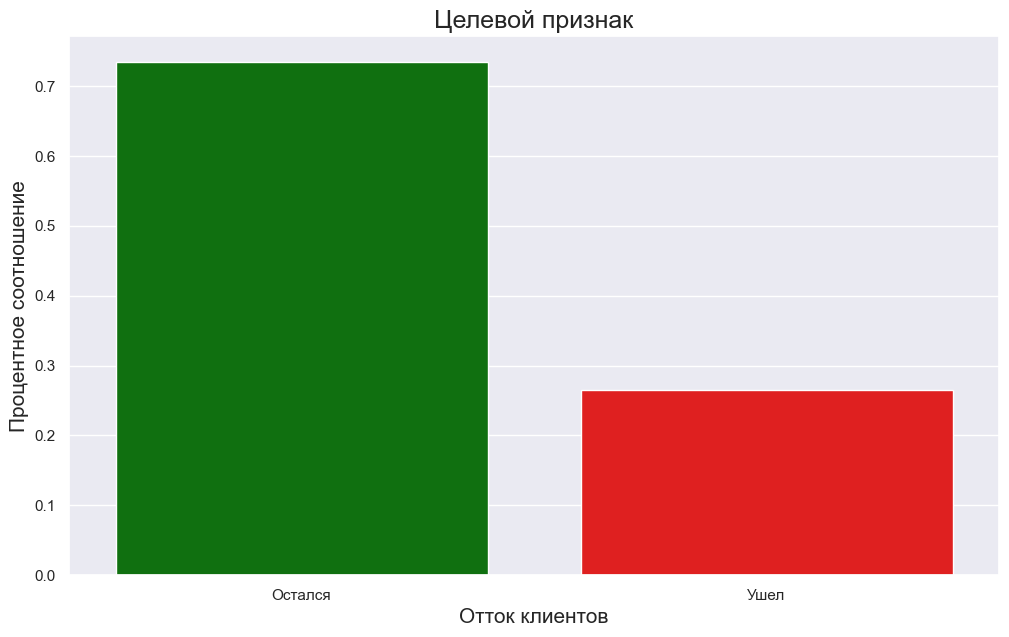

In [97]:
plt.figure(figsize=(12, 7))
plt.title("Целевой признак", fontsize=18)
ax = sns.barplot(x=data['target'].unique(),
                 y=data['target'].value_counts(normalize=True),
                 palette=['green', 'red'])

plt.xlabel("Отток клиентов", fontsize=15)
plt.ylabel("Процентное соотношение", fontsize=15)
plt.xticks(ticks=[1, 0], labels=['Ушел', 'Остался'])

plt.show()

Присутствует дисбаланс целевого признака в соотношении 74 на 26 приблизительно.

**Удаление ненужных столбцов в дальнейшем.**

In [98]:
data.drop(['begin_date', 'end_date', 'customer_id', 'gender'],
          axis=1,
          inplace=True)

**Вывод.**

В результате предобработки и иследовательского анализа:

- заполнены пропуски из-за слияния таблиц,
- подкорректирован столбец `total_charges`,
- из `end_date` выделен целевой признак `target`,
- добавлен признак с месяцем заключения контракта,
- проанализированы категориальные признаки по оттоку клиентов.

Исходя из анализа категориальных признаков можно составить приблизительный портрет ушедших клиентов:

- от пола не зависит,
- холостой,
- без детей,
- может быть пенсионером,
- в основном платит электронными деньгами (electronic check) помесячно,
- пользуется интернетом на оптике без тех.поддержки.

## Разбиение данных на выборки и обучение моделей.

### Разбиение на выборки и подготовка данных

В обучение будут использованы следующие модели:

- `DecisionTreeClassifier`,
- `CatBoostClassifier`,
- `Neural Network`.

Для первух двух будет применен `GridSearchCV` с кроссвалидацией. Выборка будет разделена 75 на 25.

Для нейросети отдельно трейн, валид и тест: 60:20:20.

**Разбиение 80:20 для `DecisionTreeClassifier`и `CatBoostClassifier`.**

In [99]:
features_train, target_train, features_test, target_test = data_split(
    data, target_col='target', test_size=0.25)

Тренировочная выборка:  (5282, 17) (5282,)
Тестовая выборка:  (1761, 17) (1761,)


**Разбиение 60:20:20 для `Neural Network`.**

In [100]:
features_train_nn, target_train_nn, features_valid_nn, target_valid_nn, features_test_nn, target_test_nn \
    = data_split(data, target_col='target', valid=True)

Тренировочная выборка:  (4225, 17) (4225,)
Валидационная выборка:  (1409, 17) (1409,)
Тестовая выборка:  (1409, 17) (1409,)


**Параметр кроссвалидации для `GridSearchCV`.**

In [101]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM)

**Числовые и категориальные столбцы для трансформера.** 

In [102]:
num_cols = features_train.select_dtypes(include=np.number).columns.tolist()
cat_cols = features_train.select_dtypes(exclude=np.number).columns.tolist()

**Транформер для преобразования столбцов.**

- количественные - MinMaxScaler(),
- категориальные - OrdinalEncoder().

In [103]:
transformer = ColumnTransformer(
    [('scaler', MinMaxScaler(), num_cols),
     ('encoder',
      OrdinalEncoder(handle_unknown='use_encoded_value',
                     unknown_value=-1), cat_cols)],
    remainder='passthrough',
    n_jobs=-1)

### Обучение моделей

#### `DecisionTreeClassifier`

**Инициализация модели.**

In [104]:
tree_model = DecisionTreeClassifier(random_state=RANDOM,
                                    class_weight='balanced')

**Пайплайн для `DecisionTreeClassifier`.**

В пайплайн так же включен метод отбора признаков `SelectKBest`.  `SelectKBest` оценивает взаимосвязь предикторов с целевой переменной используя статистические тесты, позволяя отобрать соответственно заданное количество и долю наилучших по заданному критерию признаков. В качестве статистических тестов используется хи-квадрат.

In [105]:
tree_pipeline = Pipeline(
    steps=[('col_transformer',
            transformer), ("selector", SelectKBest(chi2)), ('model',
                                                            tree_model)])

**Сетка параметров модели и селектора.**

In [106]:
params_tree = {
    'model__criterion': ['gini', 'entropy', 'log_loss'],
    'model__max_depth': np.arange(5, 20, 2),
    'model__min_samples_split': np.arange(1, 5),
    'model__min_samples_leaf': np.arange(4, 11),
    'selector__k': [15, 16, 17]
}

**Финальная сборка в `GridSearchCV`.**

In [107]:
tree_model_final = GridSearchCV(tree_pipeline,
                                params_tree,
                                cv=cv,
                                scoring='roc_auc',
                                n_jobs=-1)

**Обучение модели.**

In [108]:
tree_model_final.fit(features_train, target_train)
print(f'Модель обучена')

Модель обучена


**Результат.**

In [109]:
roc_auc_tree = tree_model_final.best_score_

print(
    f"Метрика AUC-ROC модели на тренировочной выборке с кроссвалидацией: {roc_auc_tree:.4f}"
)
print()
print(f"Лучшие гиперпараметры модели: {tree_model_final.best_params_}")

Метрика AUC-ROC модели на тренировочной выборке с кроссвалидацией: 0.8794

Лучшие гиперпараметры модели: {'model__criterion': 'gini', 'model__max_depth': 13, 'model__min_samples_leaf': 9, 'model__min_samples_split': 1, 'selector__k': 17}


#### `CatBoostClassifier`

**Балансировка целевого признака.**

In [110]:
classes = np.unique(target_train)
weights = compute_class_weight(class_weight='balanced',
                               classes=classes,
                               y=target_train)
class_weights = dict(zip(classes, weights))

**Инициализация модели.**

In [111]:
catboost_model = CatBoostClassifier(verbose=False,
                                    class_weights=class_weights,
                                    random_state=RANDOM)

**Пайплайн для `CatBoostClassifier`.**

Аналогично `DecisionTreeClassifier`.

In [112]:
catboost_pipeline = Pipeline(
    steps=[('col_transformer',
            transformer), ("selector",
                           SelectKBest(chi2)), ('model', catboost_model)])

**Сетка параметров модели и селектора.**

In [113]:
params_catboost = {
    'model__learning_rate': [1e-2, 1e-1, 1],
    'model__min_data_in_leaf': np.arange(5, 20, 5),
    'model__iterations': (500, 620, 20),
    'model__subsample': np.arange(0.1, 1, 0.2),
    'selector__k': [15, 16, 17]
}

**Финальная сборка в `GridSearchCV`.**

In [114]:
catboost_model_final = GridSearchCV(catboost_pipeline,
                                    params_catboost,
                                    cv=cv,
                                    scoring='roc_auc',
                                    n_jobs=-1)

**Обучение модели.**

In [115]:
catboost_model_final.fit(features_train, target_train)
print(f'Модель обучена')

Модель обучена


**Результат.**

In [116]:
roc_auc_catboost = catboost_model_final.best_score_

print(
    f"Метрика AUC-ROC модели на тренировочной выборке с кроссвалидацией: {roc_auc_catboost:.4f}"
)
print()
print(f"Лучшие гиперпараметры модели: {catboost_model_final.best_params_}")

Метрика AUC-ROC модели на тренировочной выборке с кроссвалидацией: 0.9474

Лучшие гиперпараметры модели: {'model__iterations': 620, 'model__learning_rate': 0.1, 'model__min_data_in_leaf': 5, 'model__subsample': 0.7000000000000001, 'selector__k': 17}


#### `Neural Network`

**Масштабирование признаков.**

In [117]:
transformer.fit(features_train_nn)
features_train_nn = transformer.transform(features_train_nn)
features_valid_nn = transformer.transform(features_valid_nn)
features_test_nn = transformer.transform(features_test_nn)

**Создание тензоров по каждой выборке.**

In [118]:
features_train_nn = torch.FloatTensor(np.array(features_train_nn))
features_valid_nn = torch.FloatTensor(np.array(features_valid_nn))
features_test_nn = torch.FloatTensor(np.array(features_test_nn))
target_train_nn = torch.FloatTensor(np.array(target_train_nn))
target_valid_nn = torch.FloatTensor(np.array(target_valid_nn))
target_test_nn = torch.FloatTensor(np.array(target_test_nn))

**Определение количества нейронов.**

In [119]:
# Входные нейроны
n_in_neurons = features_train_nn.shape[1]
# Нейроны 1-го скрытого слоя
n_hidden_neurons_1 = (n_in_neurons * 2) // 3
# Нейрон на выходе
n_out_neurons = 1

**Список с количеством нейронов для создания модели.**

In [120]:
# список для одного скрытого слоя
n_neurons_1_hidden = [n_in_neurons, n_hidden_neurons_1, n_out_neurons]

**Базовая модель нейронной сети с одним скрытым слоем.**

In [121]:
base_line = create_model(n_neurons_1_hidden)

Структура модели: Sequential(
  (0): Linear(in_features=17, out_features=11, bias=True)
  (1): ReLU()
  (2): Linear(in_features=11, out_features=1, bias=True)
  (3): Sigmoid()
)


**Определение необходимых параметров для обучения моделей.**

In [122]:
# фунуция потерь
loss_function = nn.BCELoss()

# размеры батча
batch_sizes = [4, 8, 16]

# количество эпох обучения
epochs = 500

# список коэффициентов сходимости
learning_rate_list = [0.01, 0.05, 0.1]

**Обучение моделей.**

Ниже будут обучены модели:

- 1 скрытый слой. 

Скорость обучения:

- 0.01,
- 0.05,
- 0.1

Размер батча:

- 4;
- 8, 
- 16.

Шаг проверки между эпохами:

- 5.

In [123]:
# начальное значение метрики для сравнения и выбора лучшей модели
roc_auc_nn = 0
# переменная для сохранения лучшего значения скорости обучения
best_rate = None
# переменная для сохранения лучшего размера батча
best_batch = None

# перебор коэффициентов
for rate in learning_rate_list:
    # перебор размеров батча
    for batch in batch_sizes:
        model_out, roc_auc_valid = train_and_valid(base_line,
                                                   epochs,
                                                   loss_function,
                                                   features_train_nn,
                                                   target_train_nn,
                                                   features_valid_nn,
                                                   target_valid_nn,
                                                   rate,
                                                   batch,
                                                   epoch_step=5,
                                                   show_report=True)
        # выбор лучших параметров модели
        if roc_auc_valid > roc_auc_nn:
            roc_auc_nn = roc_auc_valid
            best_rate = rate
            best_batch = batch
            nn_final = model_out


Идет обучение модели....
Обучается модель:  Sequential(
  (0): Linear(in_features=17, out_features=11, bias=True)
  (1): ReLU()
  (2): Linear(in_features=11, out_features=1, bias=True)
  (3): Sigmoid()
) 
Learning rate ---> 0.01 
Размер батча --> 4 
Шаг между эпохами на валидации --> 5 


Эпоха: 5 - AUC-ROC ---> 0.553430726704384
Эпоха: 10 - AUC-ROC ---> 0.7049148776770261
Эпоха: 15 - AUC-ROC ---> 0.7270583068537032
Эпоха: 20 - AUC-ROC ---> 0.7609754837376321
Эпоха: 25 - AUC-ROC ---> 0.8121367123924669
Эпоха: 30 - AUC-ROC ---> 0.7802875300317755
Эпоха: 35 - AUC-ROC ---> 0.8202033118912914
Эпоха: 40 - AUC-ROC ---> 0.8122607145625049
Эпоха: 45 - AUC-ROC ---> 0.8443798599808829
Эпоха: 50 - AUC-ROC ---> 0.8403355808726654
Эпоха: 55 - AUC-ROC ---> 0.8273373117362888
Эпоха: 60 - AUC-ROC ---> 0.8322353974527887
Эпоха: 65 - AUC-ROC ---> 0.8498953731690305
Эпоха: 70 - AUC-ROC ---> 0.8644333359167119
Эпоха: 75 - AUC-ROC ---> 0.8132152729339429
Эпоха: 80 - AUC-ROC ---> 0.8548167092924126
Эпоха: 

**Результат.**

In [124]:
print('Лучшая модель:\n', nn_final)
print()
print('Лучшая метрика AUC-ROC на валидации --------------> %.4f' % roc_auc_nn)
print()
print('Лучший коэффициент скорости обучения ------>', best_rate)
print()
print('Лучший размер батча ------>', best_batch)

Лучшая модель:
 Sequential(
  (0): Linear(in_features=17, out_features=11, bias=True)
  (1): ReLU()
  (2): Linear(in_features=11, out_features=1, bias=True)
  (3): Sigmoid()
)

Лучшая метрика AUC-ROC на валидации --------------> 0.9015

Лучший коэффициент скорости обучения ------> 0.01

Лучший размер батча ------> 16


**Результирующая таблица с метриками.**

In [125]:
data_rmse = {'AUC-ROC': [roc_auc_tree, roc_auc_catboost, roc_auc_nn]}

data_result = pd.DataFrame(
    data_rmse,
    index=['DecisionTreeClassifier', 'CatBoostClassifier', 'Neural Network'])

data_result

,AUC-ROC
DecisionTreeClassifier,0.879427
CatBoostClassifier,0.947365
Neural Network,0.901462


Лучший результат показала модель `CatBoostClassifier`.

В переменную `best_model` запишем лучшую модель, чтобы ниже уже использовать ее.

In [126]:
best_model = catboost_model_final.best_estimator_

## Тестирование лучшей модели

### `AUC-ROC` на тестовой выборке

In [127]:
predicted_probalities_test = best_model.predict_proba(features_test)[:, 1]

best_roc_auc_test = roc_auc_score(target_test, predicted_probalities_test)

print(f"Метрика AUC-ROC модели на тестовой выборке: {best_roc_auc_test:.4f}")

Метрика AUC-ROC модели на тестовой выборке: 0.9446


На тесте метрика 0.9446, что явно лучше завленной в 0.85 по условию.

### `ROC` кривая

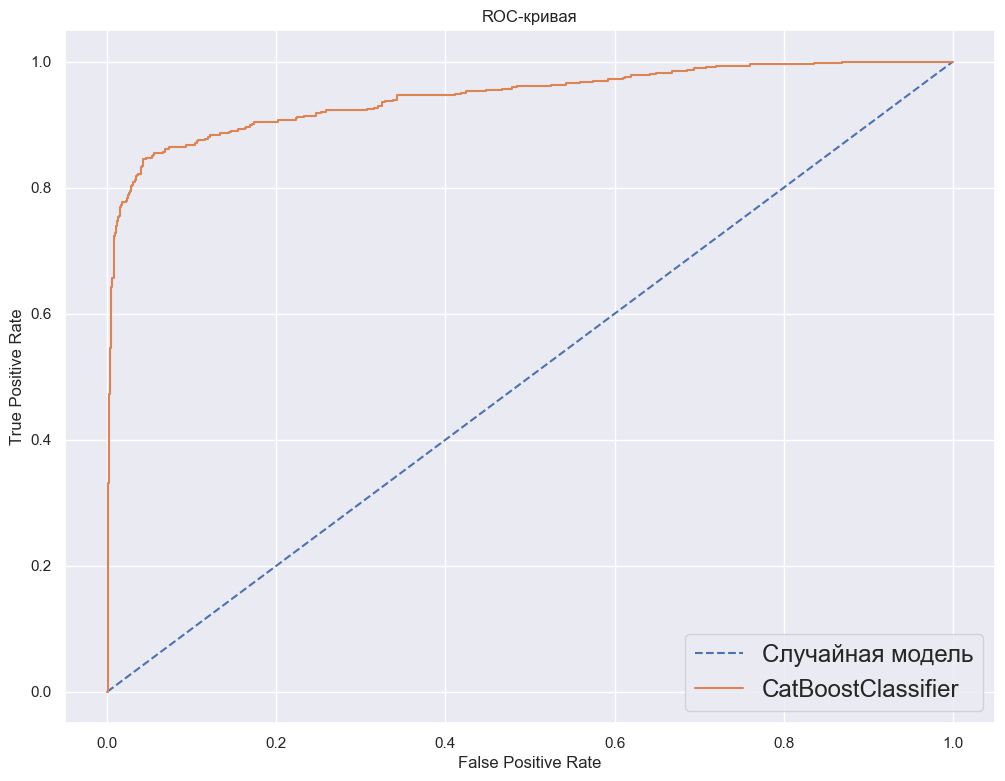

In [128]:
drow_roc_curve(target_test,
               predicted_probalities_test,
               model_name='CatBoostClassifier')

### Матрица ошибок

**Создаем матрицу.**

In [129]:
conf_matrix = confusion_matrix(target_test, best_model.predict(features_test))

**Выводим матрицу на экран.**

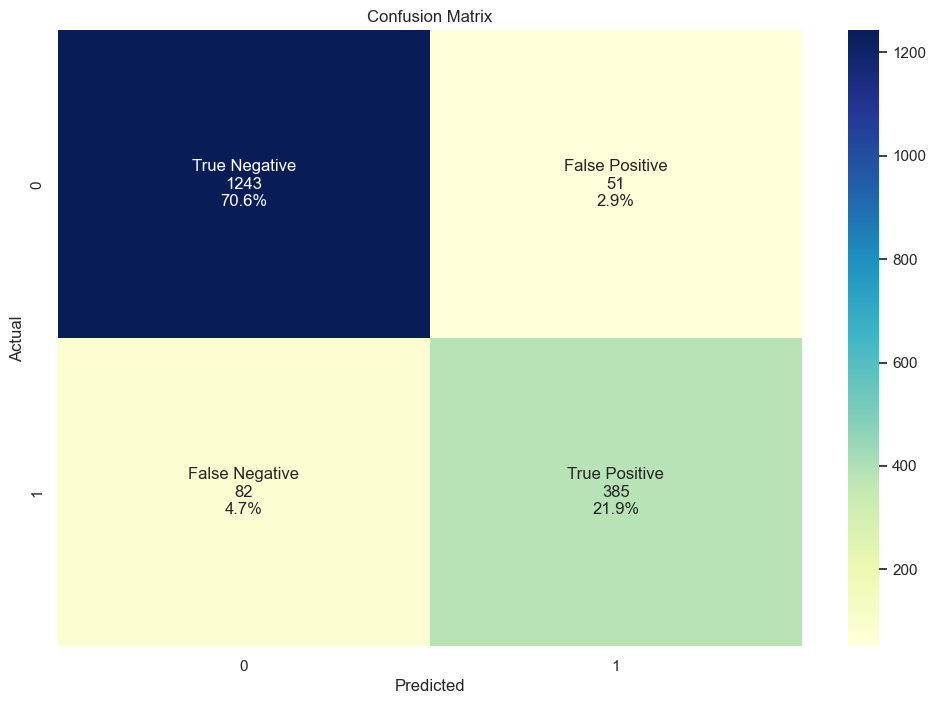

In [130]:
drow_confusion_matrix(conf_matrix)

**Результат.**

In [131]:
conf_matrix_result(conf_matrix)

Всего предсказаний: 1761
Правильно предсказанные ответы (Accuracy): 0.9245
Ошибки в прогнозах: 0.0755
Recall: 0.8244
Precision: 0.883


Что в итоге:

1. По главной диагонали (от верхнего левого угла) выстроены правильные прогнозы:
   
   - **TN** в левом верхнем углу. 1243 правильных ответов. Клиент действующий - статус соответсвует прогнозу.
   - **TP** в правом нижнем углу. 385 правильных ответов. Клиент ушёл - статус соответсвует прогнозу.

2. Вне главной диагонали — ошибочные варианты:

   - **FP** в правом верхнем углу. 51 ошибок ошибочных предсказаний первого рода. Был статус действующего клиента, а модель предсказала, что он уйдет. Компании придется применять дополнителные меры по удержанию клиента. Например скидки, что в конечном итоге снижает прибыль 
   - **FN** в левом нижнем углу. 82 ошибочных предсказаний второго рода. Был ушедшего клиента, а модель предсказала, что он не разорвёт контракт. Данное предсказание самое убыточное... Компания будучи уверенной в лояльности клиента не предпримет никаких шагов, а в результате лишится прибыли от данного клиента.
   
   
Для заказчика важно, чтобы модель правидно статус уйдет клиент или останется. Соответственно необходимо, чтобы было как можно меньше **FN**, т.к. основные убытки из-за этого типа ошибок, ну и **FP** то же важен, т.к. это уменьшение прибыли.

Метрика `Recall` получилась 82.44%,  `Precision` - 88.3%. 

Насколько это оптимальное сочетание можно проверить регулировкой `Threshold `.

Для этого для тренировочной выбоки построим pr-кривую и отметим на ней оптимальный трешход, который гармонизирует `Recall` и `Precision`. 

**PR-кривая.**

Лучший Threshold = 0.54


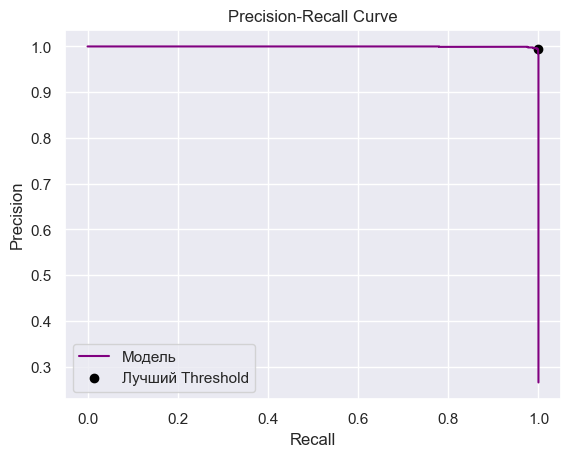

In [132]:
drow_pr_curve(features_train, target_train)

Лучший `Threshold` = 0.54

**Предсказания для лучшего `Threshold` на тестовой выборке.**

In [133]:
predictions_best_treshold = (predicted_probalities_test >= 0.54).astype('int')

**Создаем матрицу ошибок.**

In [134]:
conf_matrix_new = confusion_matrix(target_test, predictions_best_treshold)

**Вывод матрицы ошибок на экран.**

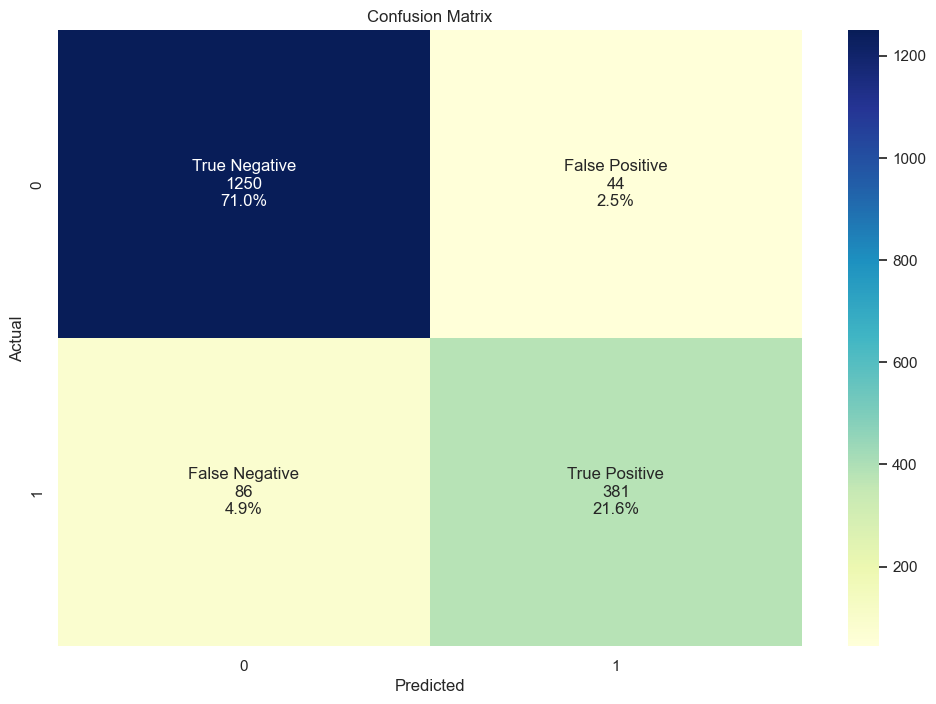

In [135]:
drow_confusion_matrix(conf_matrix_new)

**Интерпретация результата.**

In [136]:
conf_matrix_result(conf_matrix_new)

Всего предсказаний: 1761
Правильно предсказанные ответы (Accuracy): 0.9262
Ошибки в прогнозах: 0.0738
Recall: 0.8158
Precision: 0.8965


Результат такой:
 
- **TN** в левом верхнем углу. 1250 правильных ответов, а был 1243. 
- **TP** в правом нижнем углу. 381 правильных ответов, а был 385. 
- **FP** в правом верхнем углу. 44 ошибок ошибочных предсказаний первого рода, а был 51.
- **FN** в левом нижнем углу. 86 ошибочных предсказаний второго рода, а был  82
   
`Threshold` чуть-чуть улучшил пресказания по действующим контрактам, но чуть-чуть ухудшил по отттоку.   

Оставляем первый вариант. Он оказался чуть более оптимальным.

### Важность признаков

In [137]:
# индексы признаков проранжированные SelectKBest
features_idx = best_model.named_steps['selector'].get_support(indices=True)

# непосредственно имена признаков
features = features_train.columns[features_idx]

# выбор значений по важности признаков
features_importances = best_model._final_estimator.feature_importances_

# объединение всего в один датафрейм
feature_importance = pd.Series(features_importances,
                               features).to_frame().reset_index()

feature_importance.rename(columns={
    'index': 'feature',
    0: 'value'
},
    inplace=True)

# сортировка по убыванию важности признаков
feature_importance = feature_importance.sort_values(by='value',
                                                    ascending=False)

**График важности признаков.**

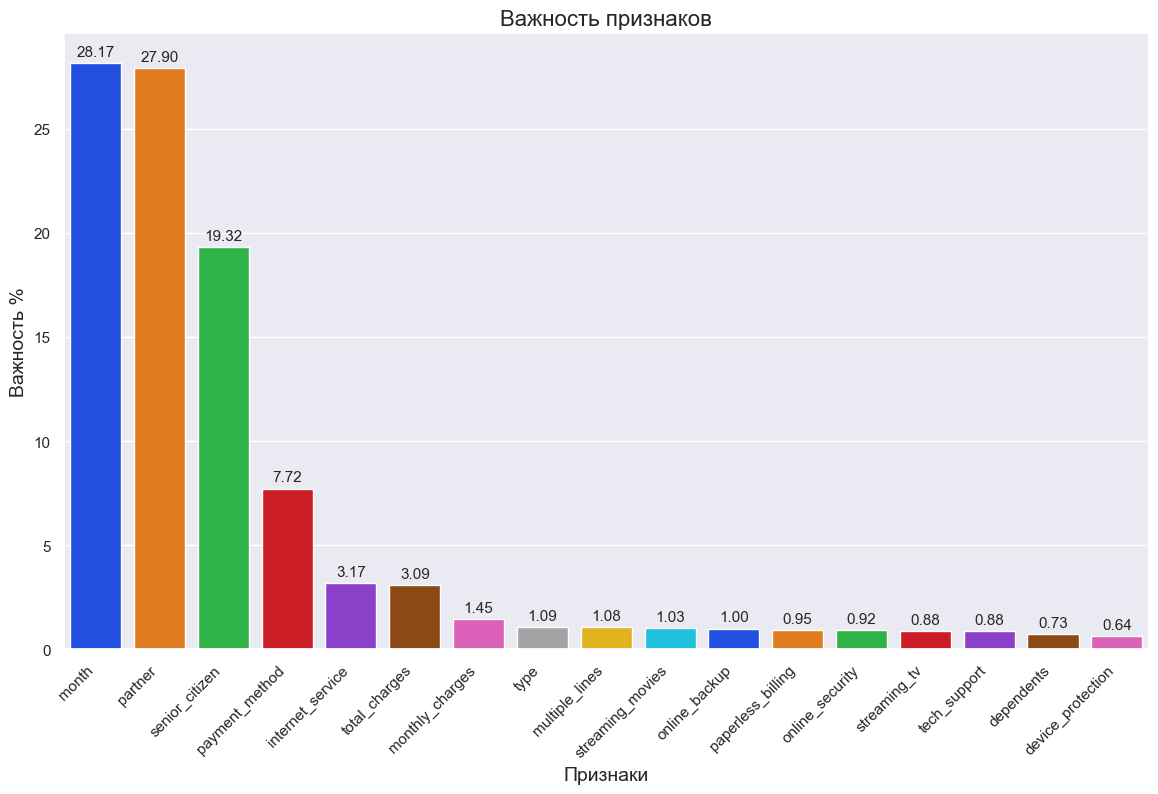

In [138]:
barplot_drow(feature_importance,
             feature_importance['feature'],
             feature_importance['value'],
             figsize=(14, 8),
             float_annot=True,
             rotation_xtick=45,
             horizontalalignment_xtick='right',
             font_xtick=11,
             size_annot=11,
             color_palette='bright',
             title_plot='Важность признаков',
             x_label='Признаки',
             y_label='Важность %',
             title_font_size=16,
             xlabel_font_size=14,
             ylabel_font_size=14)

Результат:

На первом месте месяц заключения контракта, на втором не ожиданно статус холост/женат, далее пенсионный статус...

А вот тип подключения всего-лишь на четвертом месте..

### График зависимости входного и целевого признаков.

Насколько я правильно понял, такой график можно построить при помощи `PartialDependenceDisplay`. 

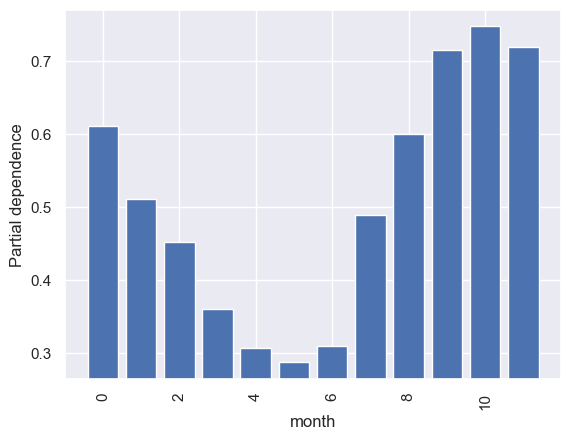

In [139]:
# выбираем самый важный признак из датафрейма с важностью признаков
best_feature = feature_importance.iloc[0][0]

# оставляем только этот признак
X = features_train.loc[:, [best_feature]]

# т.к. признак категориальный, кодируем его
le = OrdinalEncoder()

le.fit(X)

X = le.transform(X)

# т.к. кодировщик выдает только np.array возвращаем все это в датафрейм
X = pd.DataFrame(data=X, columns=[best_feature])

# лучшая модель с лучшими параметрами
tree_partial = CatBoostClassifier(iterations=620,
                                  learning_rate=0.1,
                                  min_data_in_leaf=5,
                                  subsample=0.7,
                                  verbose=False,
                                  class_weights=class_weights,
                                  random_state=RANDOM)

# переобучаем модель на одном признаке и таргете
tree_partial.fit(X, target_train)

# вывод графика на экран
PartialDependenceDisplay.from_estimator(tree_partial,
                                        X=X,
                                        n_jobs=-1,
                                        features=[best_feature],
                                        categorical_features=[best_feature],
                                        random_state=RANDOM)

plt.show()

По графику:

 `0` - `Январь` и так до `11` - `Декабрь`
Как ранеее из анализа и было видно , что отток начинал расти и июля и до декабря по номеру месяца заключения контракта.

## Вывод

В результате исследования результат по метрике `AUC-ROC` не мене 0.85 был достигнут.
Метрика на тестовых данных 0.9446.

Можно рекомендовать заказчику модель `CatBoostClassifier`.

Согласно исследовательскому анализу можно сделать выводы, что у оператора есть технические пробелы, которые нужно устранять.
- максимальный отток на оптоволокне - возможно канал не очень хороший,
- стриминговой тв и фильмы тоже видимо не очень хорошего качества.

Портрет клиента на который стоит обратить внимание:

- от пола не зависит,
- холостой,
- без детей,
- может быть пенсионером,
- в основном платит электронными деньгами (electronic check) помесячно,
- пользуется интернетом на оптике без тех.поддержки.

Для уменьшения оттока в дальшейшем можно так же рекомндовать добавить обратную связь с клиентом. Проводить опросы, возможно улучшать интерфейсы. 

Как дополнительные признаки можно добавить например: 
- среднюю скорость по каналу,
- количество конкурентов рядом,
- средню цену у конкурентов по похожему набору услуг.